In [111]:
import numpy as np
import pandas as pd
import hiive.mdptoolbox 
import hiive.mdptoolbox.mdp
import hiive.mdptoolbox.example
import mdptoolbox, mdptoolbox.example
import gym
import matplotlib.pyplot as plt
import time
from collections import Counter
import seaborn as sns

In [112]:
def analyze_param_policy(P, R, solver_type = "PI",
                 param = "gamma", param_range = [0.97, 0.98, 0.99,0.993], max_iter = 500, gamma = 0.99, epsilon_V = 0.01, display = True
                        ,epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.99,
                        alpha = 0.1, alpha_decay = 0.99, alpha_min=0.001, size = "4x4"):
    
    
    
    graph_params = ["Mean V", "Max V", "Error", "Time"]
    if solver_type == "PI":
        solver = lambda dict_args: hiive.mdptoolbox.mdp.PolicyIteration(**dict_args)
        args = {"transitions":P, "reward":R, "gamma":gamma, "max_iter":max_iter, "skip_check":True}
    elif solver_type == "VI":
        solver = lambda dict_args: hiive.mdptoolbox.mdp.ValueIteration(**dict_args)
        args = {"transitions":P, "reward":R, "gamma":gamma,"epsilon":epsilon_V, "max_iter":max_iter, "skip_check":True}
    elif solver_type == "Q":
        solver = lambda dict_args: hiive.mdptoolbox.mdp.QLearning(**dict_args)
        
        args = {"transitions":P, "reward":R, "gamma":gamma,
                "epsilon":epsilon, "epsilon_min": epsilon_min, "epsilon_decay": epsilon_decay, 
                "alpha": alpha, "alpha_decay": alpha_decay, "alpha_min":alpha_min,
                "n_iter":max_iter, "skip_check":True}
        graph_params = ["Mean V", "Max V", "Alpha","Epsilon", "Error", "Time"]
    else:
        throw("Wrong solver Type")
    
    df = pd.DataFrame(index = range(max_iter))
    for val in param_range:
        np.random.seed(252)
        args[param] = val 
        mdp = solver(args)
        #print(mdp)
        mdp.run()
        df_temp = pd.DataFrame(mdp.run_stats)
        #print(df_temp)
        df_temp = df_temp.set_index("Iteration")
        df_temp = df_temp.add_suffix("_"+ param+ "_" + str(val) + "_" + solver_type)
        
        df = df.join(df_temp)
    df.ffill(inplace= True)
    
    if display:
        plot_param(df, title =solver_type + " - " + param + " " + size, params =graph_params)
        
    print(df.shape)    
    return df

def plot_param(df, params = ["Mean V", "Max V", "Error", "Time"], title=None):      
    print(df.shape)
    for param in params:
        fitness_col = [col for col in df if col.startswith(param)]
        df_fitness = df[fitness_col]
        df_fitness.columns = [col.replace(param+'_', '') for col in df_fitness.columns]
        #print(df_fitness.columns)
        df_fitness.plot()
        
        if title != None:
            heading = param + ' - ' + title
        else:
            heading = param
        plt.title(heading, fontdict={'fontsize': 15, 'fontweight': 'heavy'})
        plt.xlabel("Iterations")
        plt.ylabel(param) 
        plt.legend()
        plt.grid()
        plt.show()
        
def plot_run_stats(mdp, title = "MDP", params = ["Mean V", "Max V", "Error", "Time"]):
    df = pd.DataFrame(mdp.run_stats)
    df = df.set_index("Iteration")
    plot_param(df, params, title)
        

In [3]:
def plotIterationGraph(df, plot1_name, plot2_name, title = "Title"):
    
    plot1_cols = [col for col in df if col.startswith(plot1_name)]
    plot2_cols = [col for col in df if col.startswith(plot2_name)]
    #df[plot1_cols].plot()
    fig, axs = plt.subplots(2)
    fig.suptitle(title,fontsize = 15, fontweight = 'heavy')
    
    df[plot1_cols].plot(ax= axs[0], legend = False, grid = True)
    axs[0].set_ylabel(plot1_name)
    
    df[plot2_cols].plot(ax= axs[1])
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel(plot2_name)
    plt.grid()
    plt.show()

In [9]:
plotIterationGraph(results, "Mean V", "Alpha", "Mean Utility Varying Alpha")

NameError: name 'results' is not defined

In [2]:

def frozen_lake_color():
    return {
        b'S': 'green',
        b'F': 'skyblue',
        b'H': 'black',
        b'G': 'gold',
    }

def directions_arrows():
    return {
        3: '⬆',
        2: '➡',
        1: '⬇',
        0: '⬅'
    }

import math

def plot_policy_map(trained_policy , env, title = "Heat Map", showUtility = False):
    policy = trained_policy.policy
    V = trained_policy.V
    # Plot heatmap
    flat_map = [item for sublist in env.unwrapped.desc for item in sublist] 
    policy_map = zip(policy, flat_map, V)
    labels = []
    font_size = 20
    for policy, square, utility in policy_map:
        annot = ""
        if square == b'S':
            annot = directions_arrows()[policy] + " (S)"
        elif square == b'H':
            annot = directions_arrows()[policy] + " (H)"
        elif square == b'G':
            annot = directions_arrows()[policy] + " (G)"
        else:
            annot = directions_arrows()[policy]
        if showUtility:
            font_size = 12
            annot = annot + " " + str('%.1f' % utility)
        labels.append(annot)
            
    length = int(math.sqrt(len(labels)))
    labels = np.array(labels).reshape(length,length)

    fig, ax = plt.subplots(figsize=(3*length/2, length))
    g = sns.heatmap(np.array(V).reshape(length, length), cmap="YlGnBu", annot=labels, fmt = '', annot_kws={"size":font_size, "fontweight":'heavy'}, ax = ax)
    ax.tick_params(labelsize=20)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)
    plt.title(title, y = 1.02, fontsize=15, fontweight ='heavy')
    plt.show()

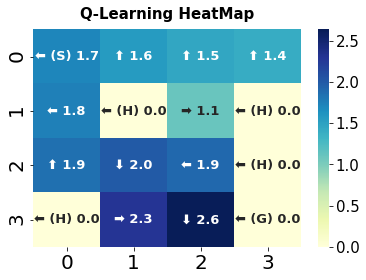

In [20]:
plot_policy_map(ql, env, "Q-Learning HeatMap", showUtility = True)

In [6]:
from gym.envs.toy_text.frozen_lake import generate_random_map
def extract_P_R_from_OpenAI(mapname):
    
#     if mapname == "FrozenLake8x8-v0":
#         np.random.seed(0)
#         flrmap = generate_random_map(size=8, p=0.8)
#         env = gym.make("FrozenLake-v0", desc=flrmap, is_slippery = True)
#     else:
#         env = gym.make(mapname)
    env = gym.make(mapname)
    env.reset()

    P = np.zeros([env.nA, env.nS, env.nS])
    R = np.zeros([env.nS, env.nA])
    
    for s in range(env.nS):
        for a in range(env.nA):
            transitions = env.P[s][a]
            for p_trans, next_s, reward, _ in transitions:
                P[a,s,next_s] += p_trans
                R[s,a] = reward
            P[a,s,:] /= np.sum(P[a,s,:])

    if mapname == "FrozenLake-v0":
        R[14,1] = 0
        R[14,2] = 1
        R[15] = 1
    if mapname == "FrozenLake8x8-v0":
        R[55,0] = 0
        R[55,1] = 1
        R[62,1] = 0
        R[62,2] = 1
        R[63] = 1
        
    env.render()
    return P,R, env
    

In [476]:
P_fl[0][14]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.33333333, 0.        , 0.        , 0.33333333, 0.33333333,
       0.        ])

In [477]:
R_fl_large

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],


In [7]:
P_fl_small, R_fl_small, env_small = extract_P_R_from_OpenAI("FrozenLake-v0")


SFFF
FHFH
FFFH
HFFG


In [8]:
P_fl, R_fl = P_fl_small, R_fl_small

In [59]:
P_fl_large, R_fl_large, env_large = extract_P_R_from_OpenAI("FrozenLake8x8-v0")                                                      


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


In [397]:
P_fl_large, R_fl_large, env_large = extract_P_R_from_OpenAI("FrozenLake8x8-v0")                                                      


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


# Small Size

In [389]:
env.render()


SFFF
FHFH
FFFH
HFFG



SFFF
FHFH
FFFH
HFFG


In [187]:
flrewards[14]

array([0., 1., 1., 1.])

In [196]:
action = 3
curr_state = 0
P_fl_large[action][curr_state]

array([0.66666667, 0.33333333, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [185]:
for action in range(4):
    state = 4
    print(str(P_fl[action][state]))

[0.33333333 0.         0.         0.         0.33333333 0.
 0.         0.         0.33333333 0.         0.         0.
 0.         0.         0.         0.        ]
[0.         0.         0.         0.         0.33333333 0.33333333
 0.         0.         0.33333333 0.         0.         0.
 0.         0.         0.         0.        ]
[0.33333333 0.         0.         0.         0.         0.33333333
 0.         0.         0.33333333 0.         0.         0.
 0.         0.         0.         0.        ]
[0.33333333 0.         0.         0.         0.33333333 0.33333333
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [154]:
env.P

{0: {0: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False)],
  1: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False),
   (0.3333333333333333, 1, 0.0, False)],
  2: [(0.3333333333333333, 4, 0.0, False),
   (0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)],
  3: [(0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)]},
 1: {0: [(0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 5, 0.0, True)],
  1: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 5, 0.0, True),
   (0.3333333333333333, 2, 0.0, False)],
  2: [(0.3333333333333333, 5, 0.0, True),
   (0.3333333333333333, 2, 0.0, False),
   (0.3333333333333333, 1, 0.0, False)],
  3: [(0.3333333333333333, 2, 0.0, False),
   (0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)]},
 2:

# PI

(10, 28)


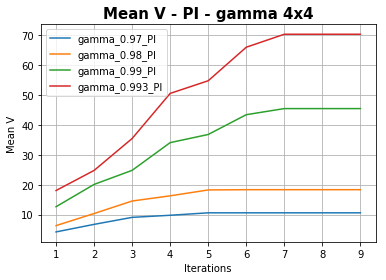

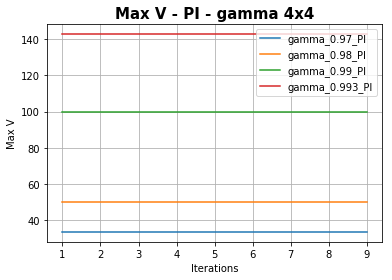

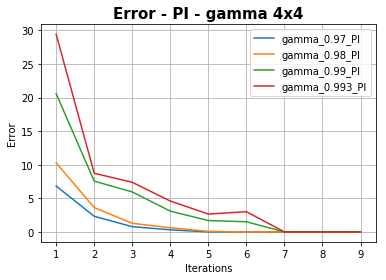

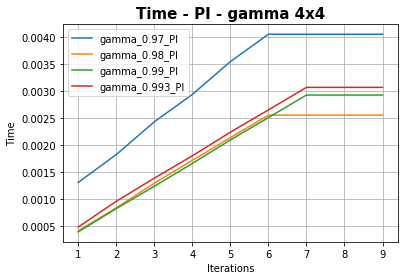

(10, 28)


In [526]:
results = analyze_param_policy(P_fl, R_fl, max_iter = 10)

(10, 21)


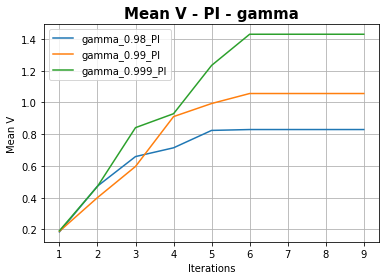

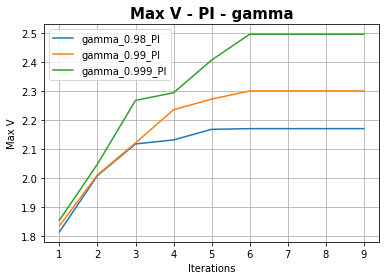

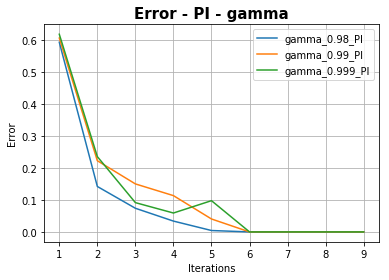

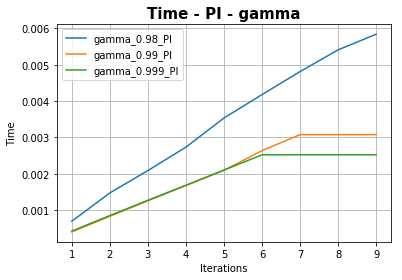

(10, 21)


In [398]:
results = analyze_param_policy(P_fl, R_fl, max_iter = 10)

In [9]:
pi = hiive.mdptoolbox.mdp.PolicyIteration(P_fl, R_fl, gamma = 0.99, max_iter=500)
pi.run()
pi.policy

(0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)

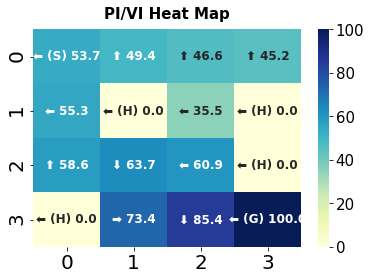

In [543]:
plot_policy_map(pi, env, "PI/VI Heat Map", showUtility=True)

In [21]:
pi = hiive.mdptoolbox.mdp.PolicyIteration(P_fl, R_fl, gamma = 0.99, max_iter=1)
pi.run()
pi.policy

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0)

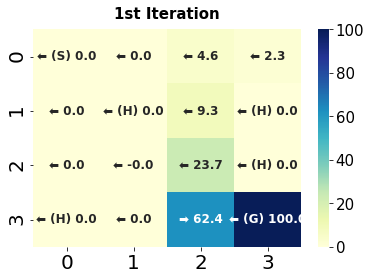

In [22]:
plot_policy_map(pi, env_small, "1st Iteration", showUtility=True)

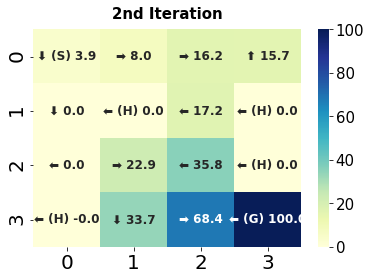

In [18]:
pi = hiive.mdptoolbox.mdp.PolicyIteration(P_fl, R_fl, gamma = 0.99, max_iter=2)
pi.run()
pi.policy
plot_policy_map(pi, env_small, "2nd Iteration", showUtility=True)

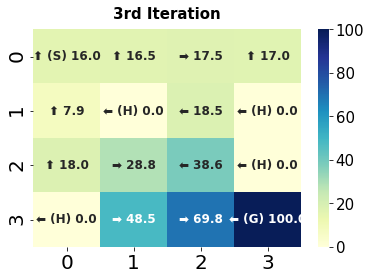

In [19]:
pi = hiive.mdptoolbox.mdp.PolicyIteration(P_fl, R_fl, gamma = 0.99, max_iter=3)
pi.run()
pi.policy
plot_policy_map(pi, env_small, "3rd Iteration", showUtility=True)

<Figure size 576x576 with 0 Axes>

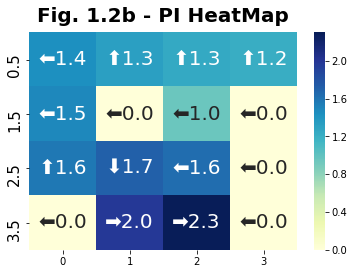

In [400]:
# Plot heatmap
pi_policy = zip(pi.policy, pi.V)

labels = [directions_arrows()[policy] + str('%.1f' % value) for policy, value in pi_policy]
labels = np.array(labels).reshape(4, 4)
plt.figure(figsize=(8, 8))
fig, ax = plt.subplots()
ax = sns.heatmap(np.array(pi.V).reshape(4, 4), cmap="YlGnBu", annot=labels, fmt = '', annot_kws={"size":20})
ax.set_yticklabels(ax.get_yticks(), size = 15)
#g.fig.suptitle("Fig. 1.2b - Breast Cancer", y = 1.02, fontsize=20, fontweight ='heavy')
plt.title("Fig. 1.2b - PI HeatMap", y = 1.02, fontsize=20, fontweight ='heavy')
plt.show()

In [133]:
# Plot heatmap
flat_map = [item for sublist in env.unwrapped.desc for item in sublist] 
policy_map = zip(pi.policy, flat_map)
labels = []

for policy, square in policy_map:
    if square == b'S':
        labels.append(directions_arrows()[policy] + " (S)")
    elif square == b'H':
        labels.append(directions_arrows()[policy] + " (H)")
    elif square == b'G':
        labels.append(directions_arrows()[policy] + " (G)")
    else:
        labels.append(directions_arrows()[policy])

labels = np.array(labels).reshape(4, 4)
plt.figure(figsize=(8, 8))
fig, ax = plt.subplots()
ax = sns.heatmap(np.array(pi.V).reshape(4, 4), cmap="YlGnBu", annot=labels, fmt = '', annot_kws={"size":20})
#g.fig.suptitle("Fig. 1.2b - Breast Cancer", y = 1.02, fontsize=20, fontweight ='heavy')
plt.title("Fig. 1.2b - PI HeatMap", y = 1.02, fontsize=20, fontweight ='heavy')
plt.show()


NameError: name 'pi' is not defined

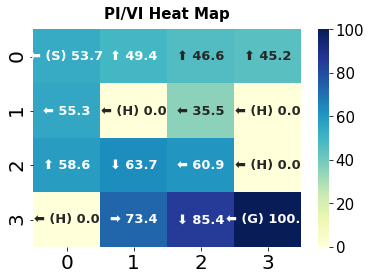

In [408]:
plot_policy_map(pi, env, "PI/VI Heat Map", showUtility=True)

In [ ]:
mdp

<Figure size 576x576 with 0 Axes>

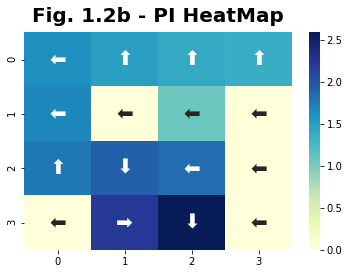

In [55]:
# Plot heatmap
labels = [directions_arrows()[x] for x in pi.policy]
labels = np.array(labels).reshape(4, 4)
plt.figure(figsize=(8, 8))
fig, ax = plt.subplots()
ax = sns.heatmap(np.array(pi.V).reshape(4, 4), cmap="YlGnBu", annot=labels, fmt = '', annot_kws={"size":20})
#g.fig.suptitle("Fig. 1.2b - Breast Cancer", y = 1.02, fontsize=20, fontweight ='heavy')
plt.title("Fig. 1.2b - PI HeatMap", y = 1.02, fontsize=20, fontweight ='heavy')
plt.show()

<Figure size 576x576 with 0 Axes>

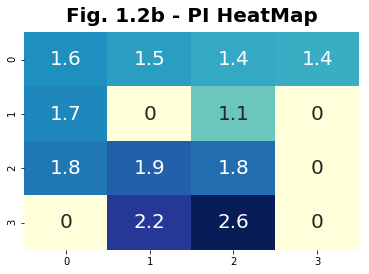

In [22]:
# Plot heatmap
plt.figure(figsize=(8, 8))
fig, ax = plt.subplots()
fig = sns.heatmap(np.array(vi.V).reshape(4, 4),  cmap="YlGnBu", annot=True, cbar=False,annot_kws={"size":20})
#g.fig.suptitle("Fig. 1.2b - Breast Cancer", y = 1.02, fontsize=20, fontweight ='heavy')
plt.title("Fig. 1.2b - PI HeatMap", y = 1.02, fontsize=20, fontweight ='heavy')
plt.show()

# VI

(1000, 28)


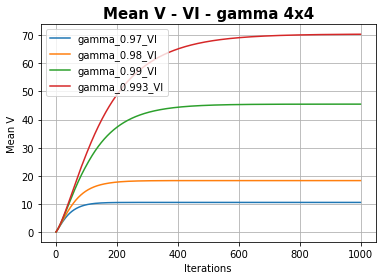

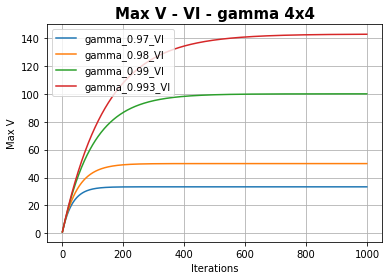

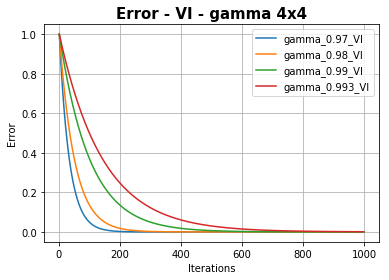

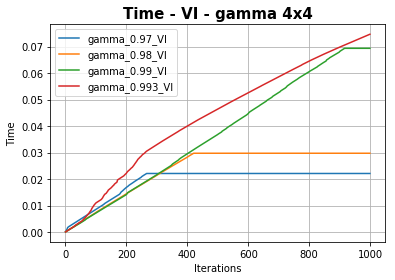

(1000, 28)


In [540]:
results = analyze_param_policy(P_fl, R_fl, solver_type="VI", max_iter = 1000)

(250, 21)


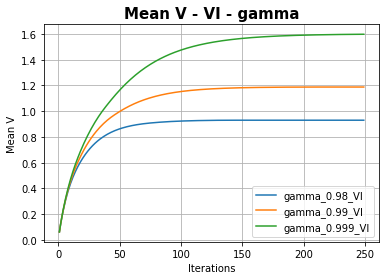

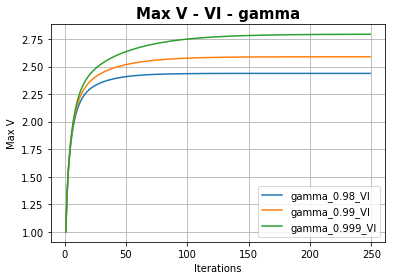

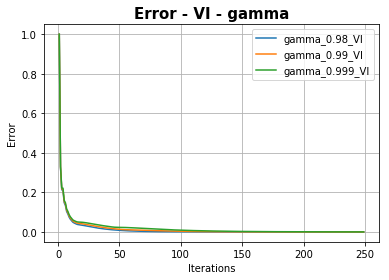

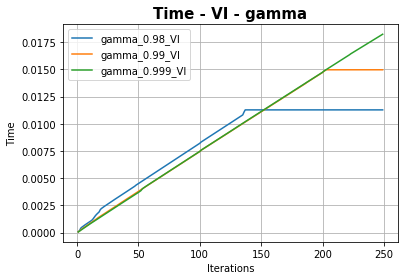

(250, 21)


In [135]:
results = analyze_param_policy(P_fl, R_fl, solver_type="VI", max_iter = 250)

In [60]:
R_fl_high_reward = R_fl
R_fl[-2][1] = 1

#R_fl = R_fl_high_reward

In [27]:
vi = hiive.mdptoolbox.mdp.ValueIteration(P_fl, R_fl, gamma = 0.99, max_iter=500)
vi.run()
vi.policy

(0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)

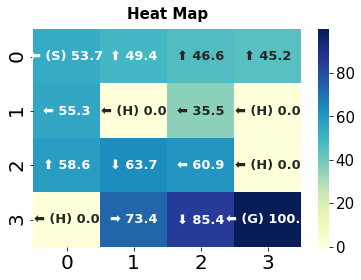

In [488]:
plot_policy_map(vi, env, showUtility=True)

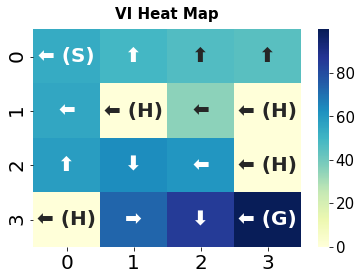

In [411]:
plot_policy_map(vi, env, "VI Heat Map")

In [ ]:
results = analyze_param_policy(P_fl, R_fl, solver_type = "Q", max_iter=500000,  epsilon = 1, epsilon_decay = 0.9999,
                               alpha = 0.5, alpha_decay = 0.99999)

(500000, 50)


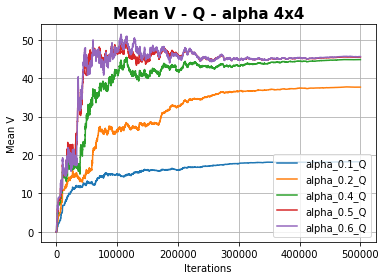

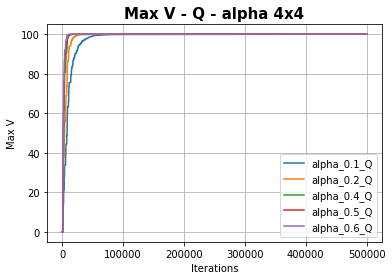

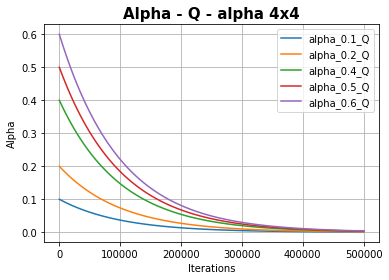

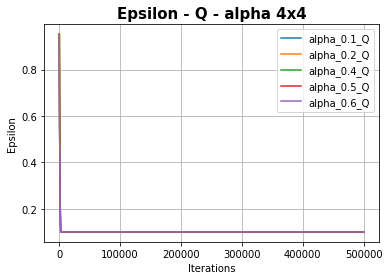

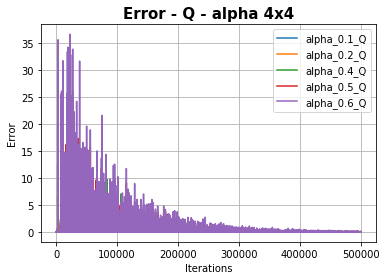

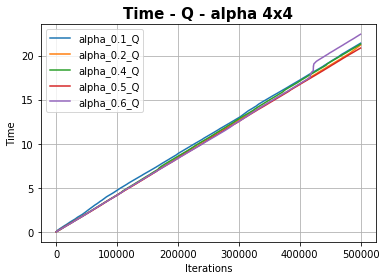

(500000, 50)


In [544]:
results = analyze_param_policy(P_fl, R_fl, solver_type = "Q", max_iter=500000, epsilon = 1, epsilon_decay = 0.999,
                               param = "alpha", param_range = [0.1, 0.2,0.4, 0.5, 0.6], alpha_decay = 0.99999)

(500000, 50)


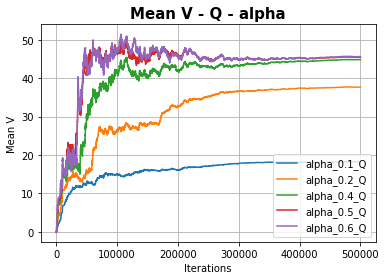

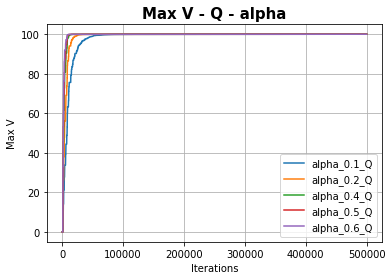

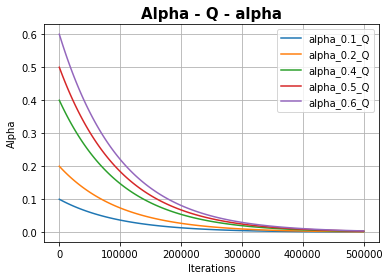

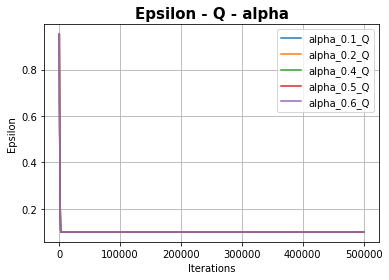

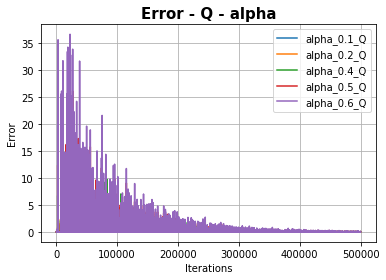

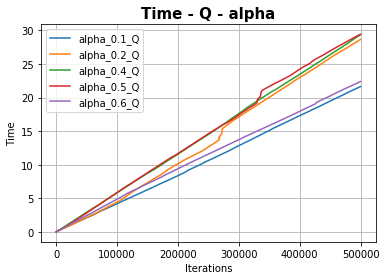

(500000, 50)


In [413]:
results = analyze_param_policy(P_fl, R_fl, solver_type = "Q", max_iter=500000, epsilon = 1, epsilon_decay = 0.999,
                               param = "alpha", param_range = [0.1, 0.2,0.4, 0.5, 0.6], alpha_decay = 0.99999)

(500000, 50)


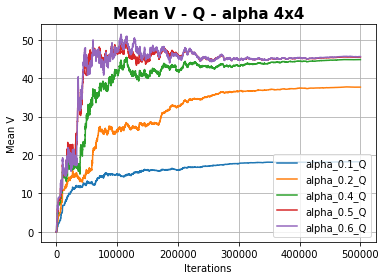

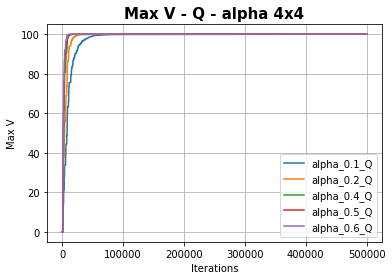

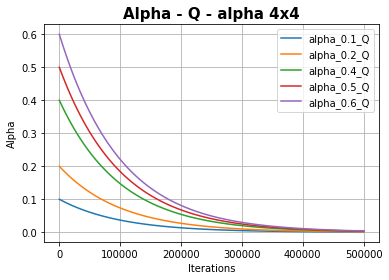

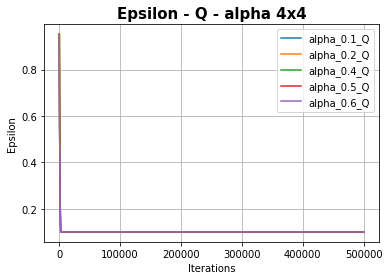

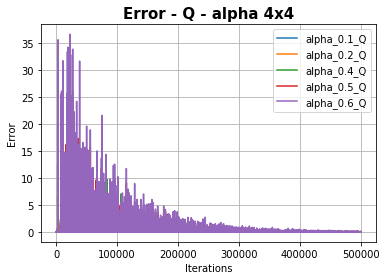

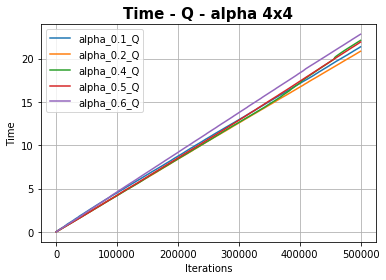

(500000, 50)


In [545]:
results = analyze_param_policy(P_fl, R_fl, solver_type = "Q", max_iter=500000, epsilon = 1, epsilon_decay = 0.999,
                               param = "alpha", param_range = [0.1, 0.2,0.4, 0.5, 0.6], alpha_decay = 0.99999)

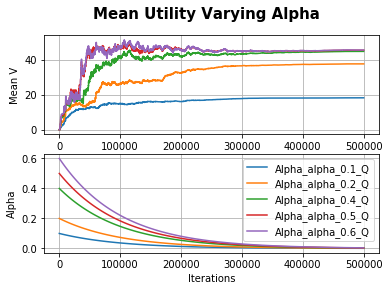

In [546]:
plotIterationGraph(results, "Mean V", "Alpha", "Mean Utility Varying Alpha")

(500000, 40)


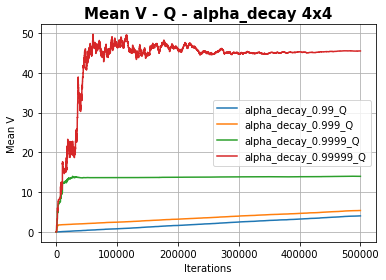

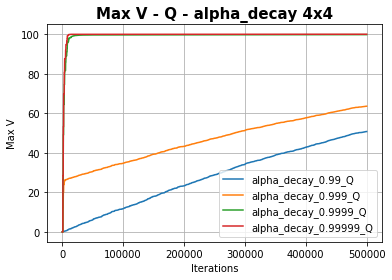

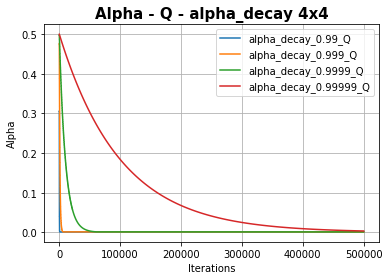

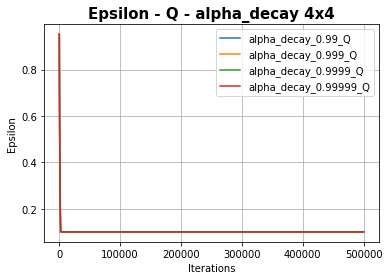

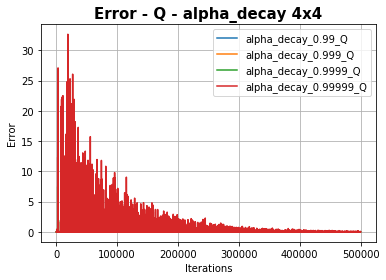

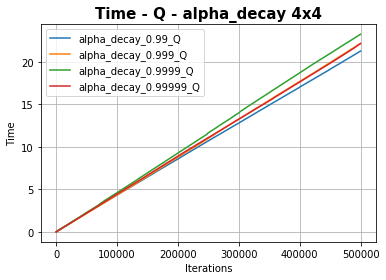

(500000, 40)


In [547]:
results = analyze_param_policy(P_fl, R_fl, solver_type = "Q", max_iter=500000, epsilon = 1, epsilon_decay = 0.999,
                               param = "alpha_decay", param_range = [0.99, 0.999,0.9999, 0.99999], alpha = 0.5)

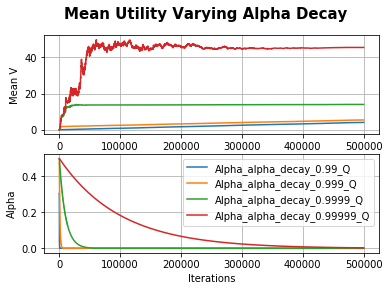

In [548]:
plotIterationGraph(results, "Mean V", "Alpha", "Mean Utility Varying Alpha Decay")

(500000, 40)


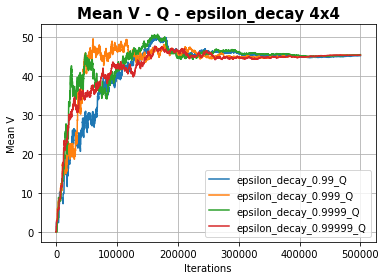

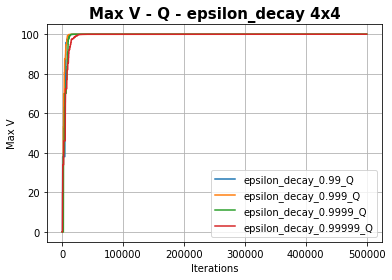

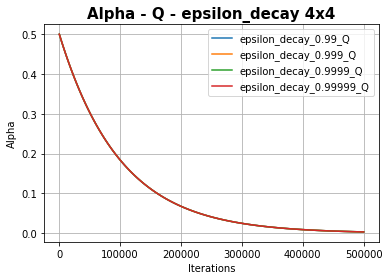

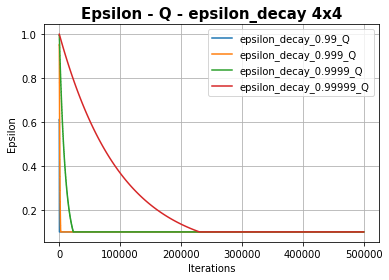

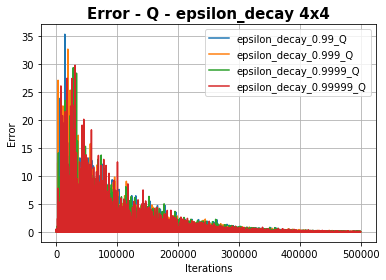

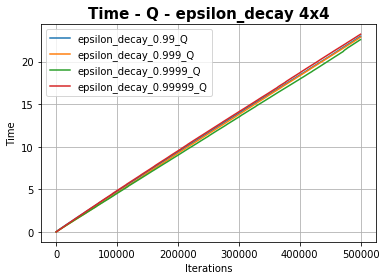

(500000, 40)


In [549]:
results = analyze_param_policy(P_fl, R_fl, solver_type = "Q", max_iter=500000, epsilon = 1, alpha_decay = 0.99999,
                               param = "epsilon_decay", param_range = [0.99, 0.999,0.9999, 0.99999], alpha = 0.5)

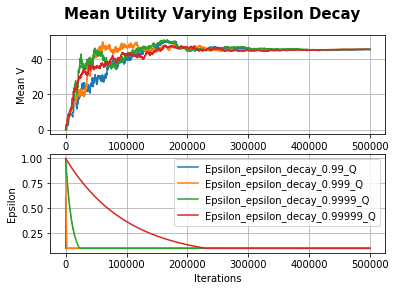

In [550]:
plotIterationGraph(results, "Mean V", "Epsilon", "Mean Utility Varying Epsilon Decay")

(500000, 50)


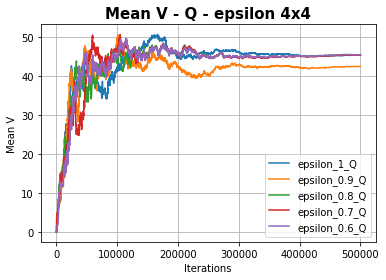

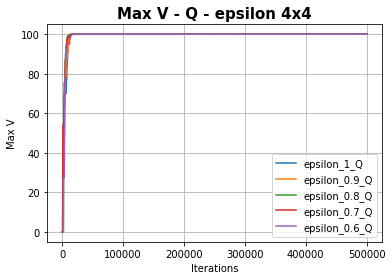

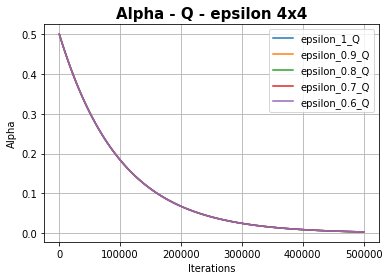

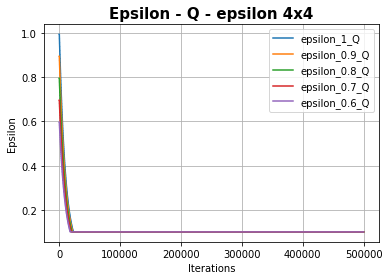

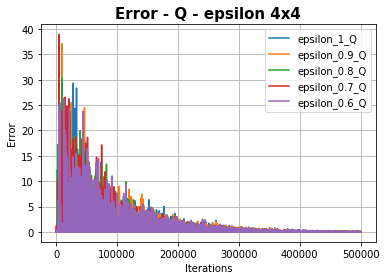

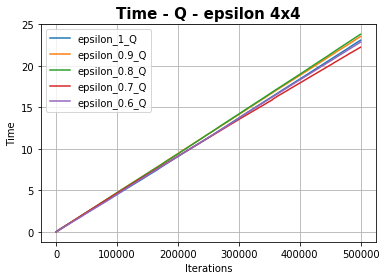

(500000, 50)


In [551]:
results = analyze_param_policy(P_fl, R_fl, solver_type = "Q", max_iter=500000, epsilon_decay = 0.9999, alpha_decay = 0.99999,
                               param = "epsilon", param_range = [1, 0.9, 0.8, 0.7, 0.6], alpha = 0.5)

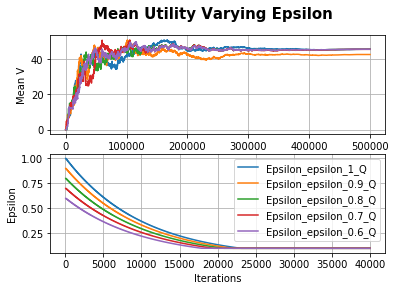

In [552]:
plot1_name = "Mean V"
plot2_name = "Epsilon"
plot1_cols = [col for col in results if col.startswith(plot1_name)]
plot2_cols = [col for col in results if col.startswith(plot2_name)]
#df[plot1_cols].plot()
fig, axs = plt.subplots(2)
fig.suptitle("Mean Utility Varying Epsilon",fontsize = 15, fontweight = 'heavy')

results[plot1_cols].plot(ax= axs[0], legend = False, grid = True)
axs[0].set_ylabel(plot1_name)

results[:40000][plot2_cols].plot(ax= axs[1])
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel(plot2_name)
plt.grid()
plt.show()

(2000000, 40)


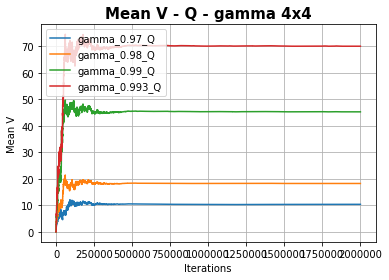

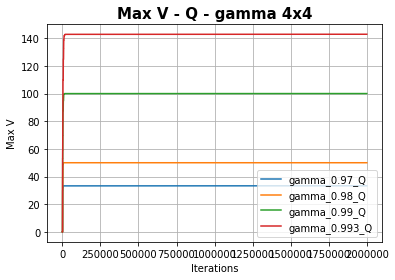

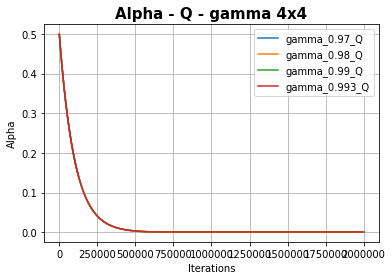

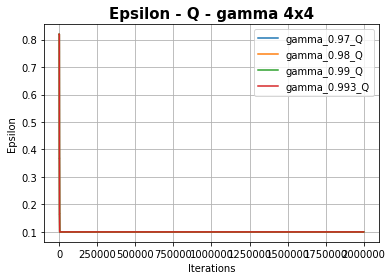

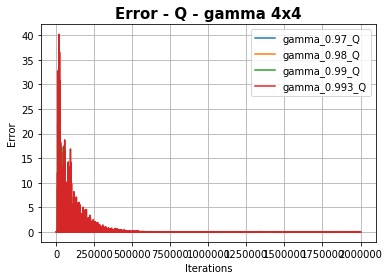

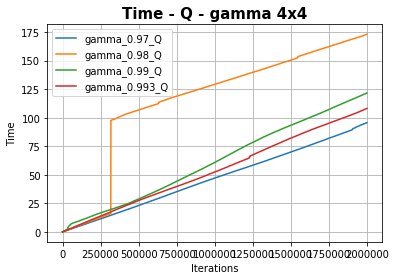

(2000000, 40)


In [553]:
results = analyze_param_policy(P_fl, R_fl, solver_type = "Q", max_iter=2000000, epsilon = 1, epsilon_decay = 0.999,
                               alpha = 0.5, alpha_decay = 0.99999)

(500000, 30)


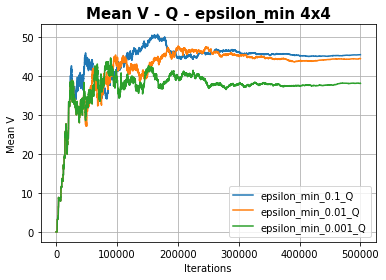

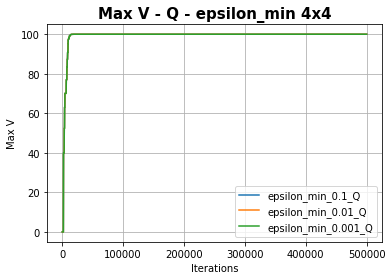

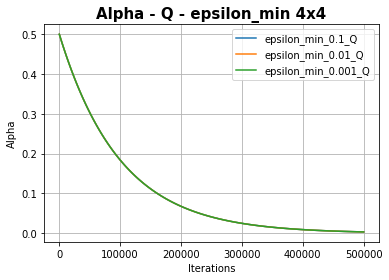

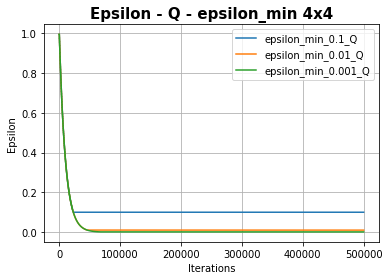

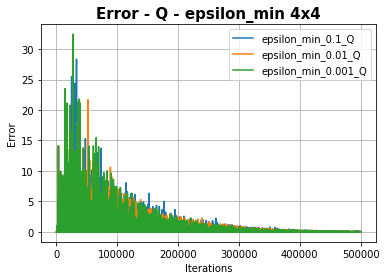

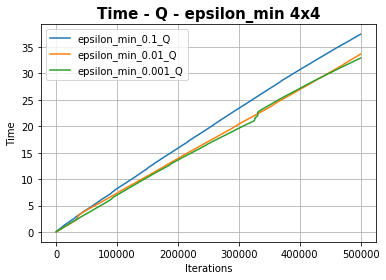

(500000, 30)


In [554]:
results = analyze_param_policy(P_fl, R_fl, solver_type = "Q", max_iter=500000, epsilon_decay = 0.9999, alpha_decay = 0.99999, epsilon =1,
                               param = "epsilon_min", param_range = [0.1,0.01,0.001], alpha = 0.5)

In [555]:
np.random.seed(252)
ql = hiive.mdptoolbox.mdp.QLearning(P_fl, R_fl, 0.99, n_iter = 10**6 , epsilon = 1, epsilon_decay = 0.9999,
                               alpha = 0.5, alpha_decay = 0.99999, skip_check=True)
ql.run()


[{'State': 6,
  'Action': 2,
  'Reward': 0.0,
  'Error': 0.0,
  'Time': 0.008196115493774414,
  'Alpha': 0.49950524247159656,
  'Epsilon': 0.9901483535267248,
  'Gamma': 0.99,
  'Max V': 0.0,
  'Mean V': 0.0,
  'Iteration': 100},
 {'State': 0,
  'Action': 0,
  'Reward': 0.0,
  'Error': 0.0,
  'Time': 0.015187978744506836,
  'Alpha': 0.4990059844034716,
  'Epsilon': 0.9802957226154846,
  'Gamma': 0.99,
  'Max V': 0.0,
  'Mean V': 0.0,
  'Iteration': 200},
 {'State': 4,
  'Action': 1,
  'Reward': 0.0,
  'Error': 0.0,
  'Time': 0.020902156829833984,
  'Alpha': 0.49850722534636305,
  'Epsilon': 0.9705411318974407,
  'Gamma': 0.99,
  'Max V': 0.0,
  'Mean V': 0.0,
  'Iteration': 300},
 {'State': 12,
  'Action': 3,
  'Reward': 0.0,
  'Error': 0.0,
  'Time': 0.026607990264892578,
  'Alpha': 0.49800896480150686,
  'Epsilon': 0.9608836058078369,
  'Gamma': 0.99,
  'Max V': 0.0,
  'Mean V': 0.0,
  'Iteration': 400},
 {'State': 14,
  'Action': 1,
  'Reward': 0.0,
  'Error': 0.0,
  'Time': 0.03280

(10000, 10)


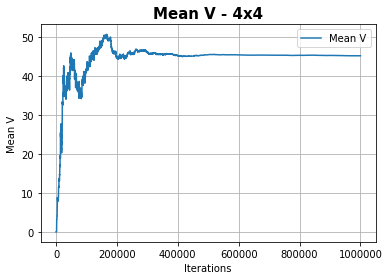

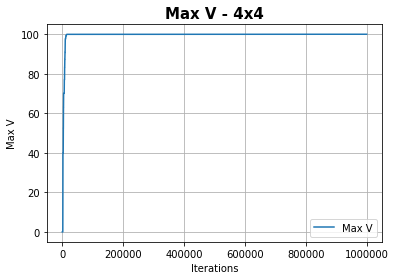

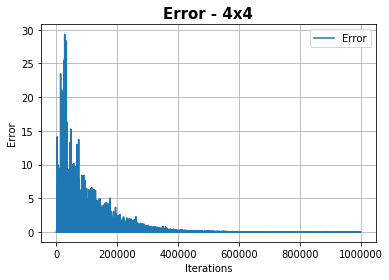

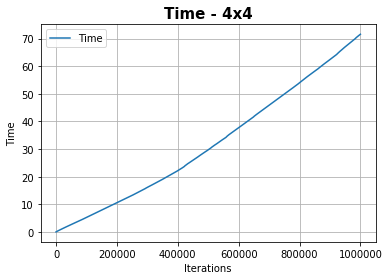

In [559]:
plot_run_stats(ql, "4x4")

In [3]:
plot_policy_map('Frozen Lake Q Learning'
                ,policy.reshape(4,4),desc,frozen_lake_color(),directions_arrows())


NameError: name 'policy' is not defined

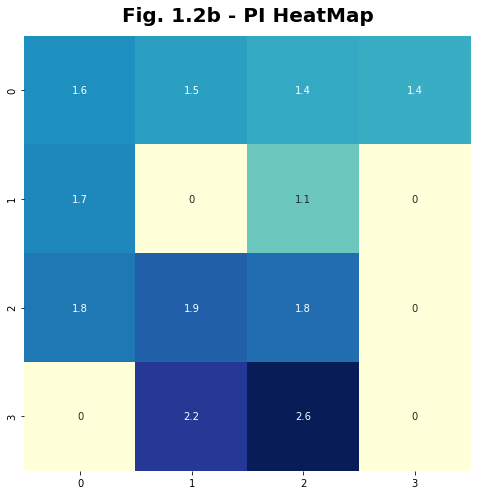

In [68]:
# Plot heatmap
plt.figure(figsize=(8, 8))
g = sns.heatmap(np.array(vi.V).reshape(4, 4),  cmap="YlGnBu", annot=True, cbar=False)
#g.fig.suptitle("Fig. 1.2b - Breast Cancer", y = 1.02, fontsize=20, fontweight ='heavy')
plt.title("Fig. 1.2b - PI HeatMap", y = 1.02, fontsize=20, fontweight ='heavy')
plt.show()

In [84]:
# Plot heatmap
plt.figure(figsize=(8, 8))
g = sns.heatmap(np.array(pi.V).reshape(4, 4),  cmap="YlGnBu", annot=True, cbar=False)
#g.fig.suptitle("Fig. 1.2b - Breast Cancer", y = 1.02, fontsize=20, fontweight ='heavy')
plt.title("Fig. 1.2b - PI HeatMap", y = 1.02, fontsize=20, fontweight ='heavy')
plt.show()

NameError: name 'pi' is not defined

<Figure size 576x576 with 0 Axes>

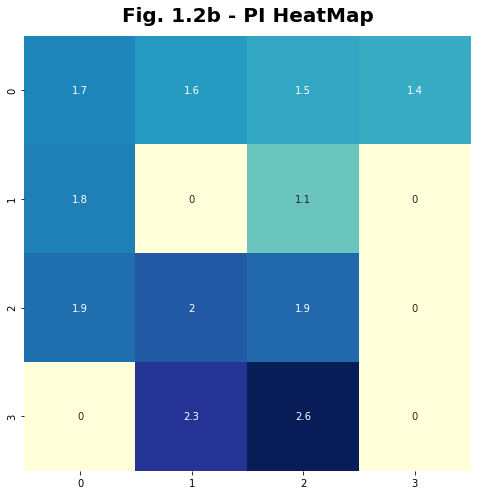

In [83]:
# Plot heatmap
plt.figure(figsize=(8, 8))
g = sns.heatmap(np.array(ql.V).reshape(4, 4),  cmap="YlGnBu", annot=True, cbar=False)
#g.fig.suptitle("Fig. 1.2b - Breast Cancer", y = 1.02, fontsize=20, fontweight ='heavy')
plt.title("Fig. 1.2b - QL HeatMap", y = 1.02, fontsize=20, fontweight ='heavy')
plt.show()

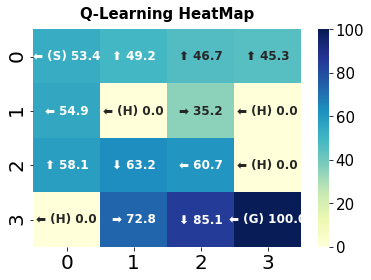

In [558]:
plot_policy_map(ql, env, "Q-Learning HeatMap", showUtility = True)


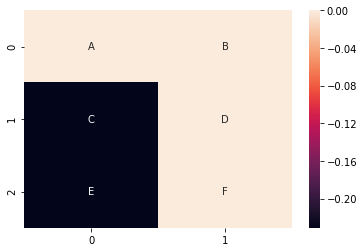

In [190]:
data = np.array([[0.000000,0.000000],[-0.231049,0.000000],[-0.231049,0.000000]])
labels =  np.array([['A','B'],['C','D'],['E','F']])
fig, ax = plt.subplots()
ax = sns.heatmap(data, annot = labels, fmt = '')

In [82]:
    
def tile():
    return {
    b'S': 'S',
    b'F': 'F',
    b'H': 'H',
    b'G': 'G',
    }


def plot_policy_map_old(title, policy, map_desc, color_map, direction_map):
#     policy = np.array(policy)
#     policy = policy.reshape(4,4)
    fig = plt.figure()
    ax = fig.add_subplot(111, xlim=(0, policy.shape[1]), ylim=(0, policy.shape[0]))
    font_size = 'x-large'
    if policy.shape[1] > 16:
        font_size = 'small'
    plt.title(title, y = 1.02, fontsize=15, fontweight ='heavy')
    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]):
            y = policy.shape[0] - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1)
            p.set_facecolor(color_map[map_desc[i,j]])
            
            ax.add_patch(p)

            text = ax.text(x+0.5, y+0.5, tile()[map_desc[i,j]], weight='bold', size=20,
                           horizontalalignment='center', verticalalignment='center', color='w')


    plt.axis('off')
    plt.xlim((0, policy.shape[1]))
    plt.ylim((0, policy.shape[0]))
    plt.tight_layout()
    plt.show()

    return (plt)

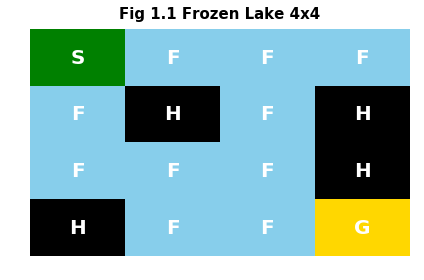

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [83]:
li = np.array(vi.policy)
plot_policy_map_old('Fig 1.1 Frozen Lake 4x4',li.reshape(4,4),env_small.env.desc,frozen_lake_color(),directions_arrows())

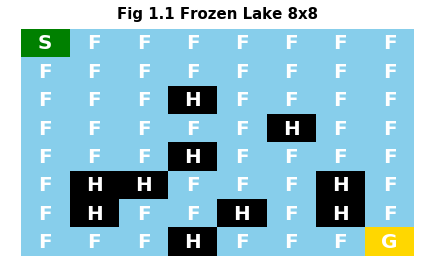

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [85]:
li =  np.array(pi_large.policy)
plot_policy_map_old('Fig 1.1 Frozen Lake 8x8',li.reshape(8,8),env_large.env.desc,frozen_lake_color(),directions_arrows())

# Large Size

(15, 28)


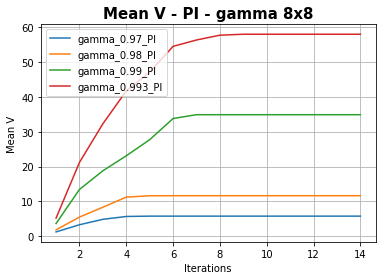

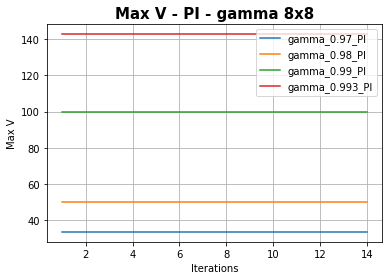

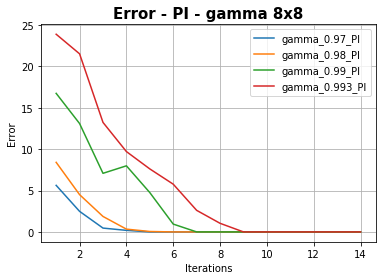

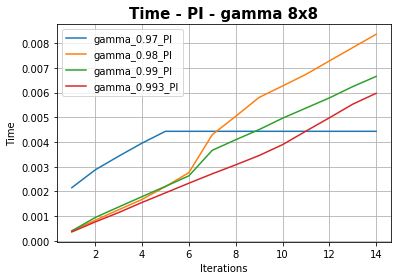

(15, 28)


In [527]:
results = analyze_param_policy(P_fl_large, R_fl_large, max_iter = 15, size = "8x8")

(15, 21)


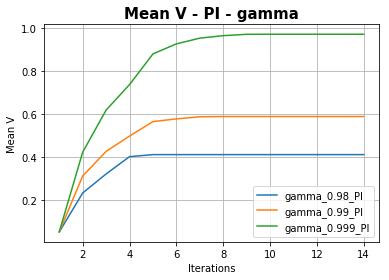

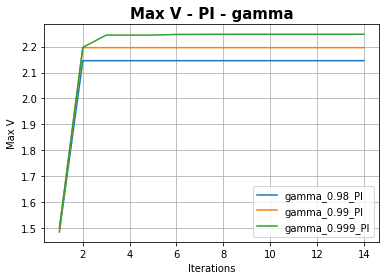

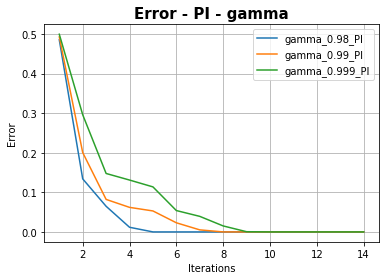

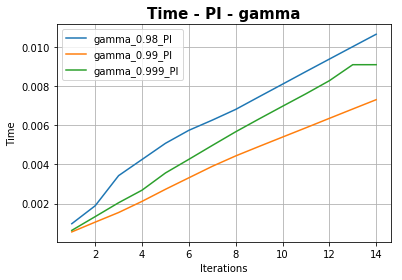

(15, 21)


In [86]:
results = analyze_param_policy(P_fl_large, R_fl_large, max_iter = 15)

In [506]:
P_fl_large

array([[[0.66666667, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.33333333, 0.33333333, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.33333333, 0.33333333, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.33333333,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.33333333,
         0.33333333, 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 1.        ]],

       [[0.33333333, 0.33333333, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.33333333, 0.        , 0.33333333, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.33333333, 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.33333333,
         0.33333333, 0.        ],
        [0. 

In [60]:
pi_large = hiive.mdptoolbox.mdp.PolicyIteration(P_fl_large, R_fl_large, gamma = 0.99, max_iter=1000)
pi_large.run()
test = pi_large.policy

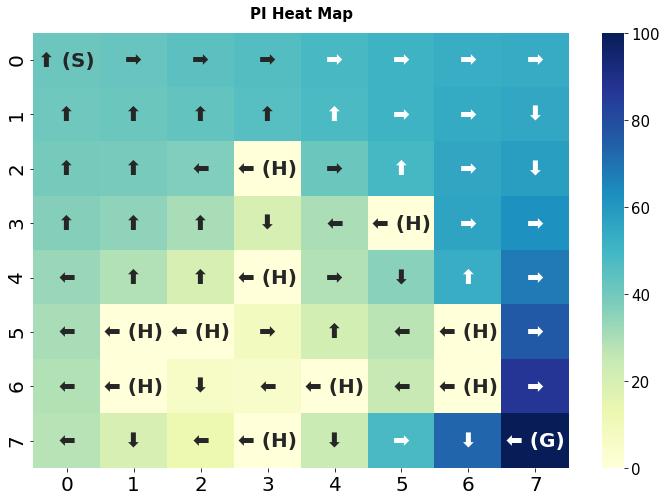

In [533]:
plot_policy_map(pi_large, env_large, "PI Heat Map")

In [218]:
P_fl_large[2][62]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.33333333,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.33333333, 0.33333333])

In [224]:
P_fl_large[3][54]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [225]:
R

NameError: name 'R' is not defined

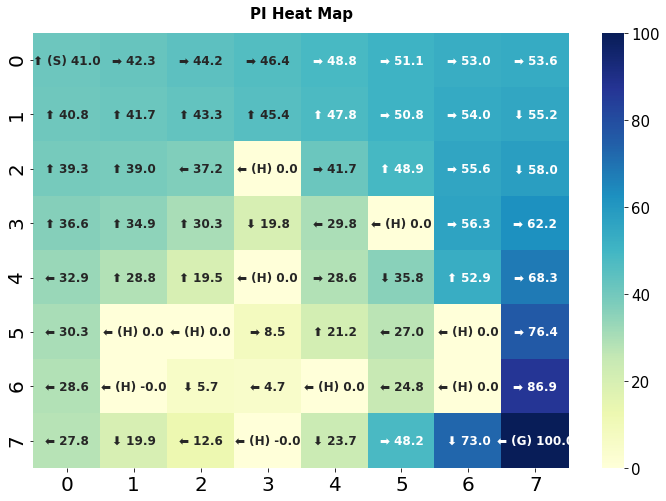

In [534]:
plot_policy_map(pi_large, env_large, "PI Heat Map", showUtility = True)

In [ ]:
plot_policy_map(pi_large, env_large, "PI Heat Map")

(1200, 28)


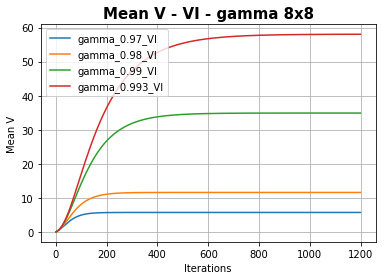

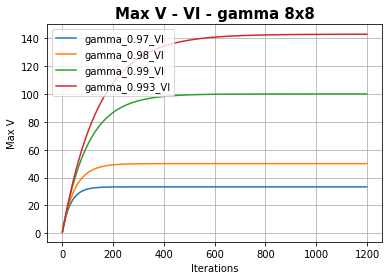

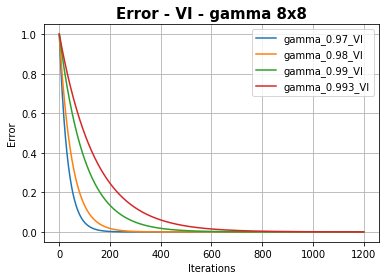

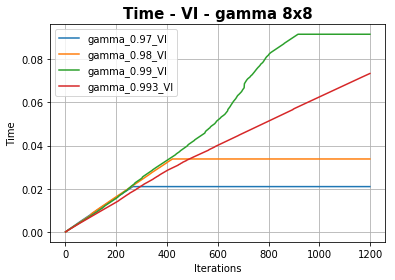

(1200, 28)


In [542]:
results = analyze_param_policy(P_fl_large, R_fl_large, solver_type="VI", max_iter = 1200, size = "8x8")

(500, 21)


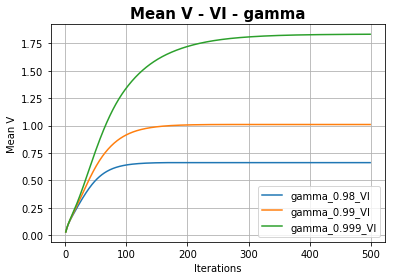

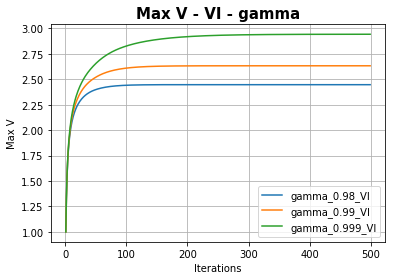

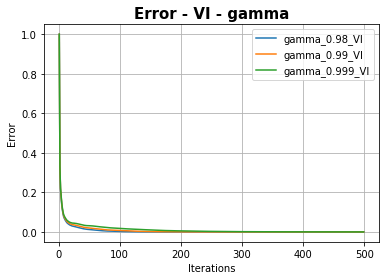

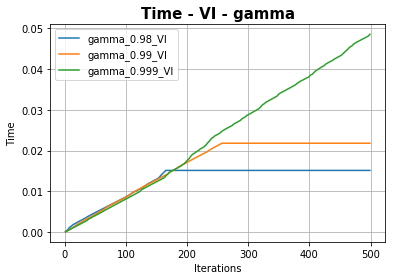

(500, 21)


In [466]:
results = analyze_param_policy(P_fl_large, R_fl_large, solver_type="VI", max_iter = 500)

In [535]:
vi_large = hiive.mdptoolbox.mdp.ValueIteration(P_fl_large, R_fl_large, gamma = 0.99, epsilon= 0.00001, max_iter=5000)
test=vi_large.run()
#vi_large.policy

In [374]:
R_fl_large[63] =1

In [357]:
type(vi_large.V)

tuple

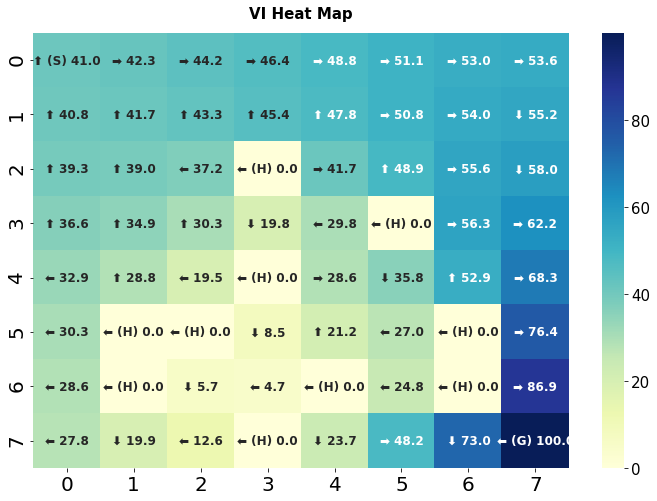

In [536]:
plot_policy_map(vi_large, env_large, "VI Heat Map", showUtility=True)

In [323]:
if state = last-1 and action = right Reward = 1
then prob up down right

prob up down right
if state = last-1 and action = right Reward = 1


SyntaxError: invalid syntax (<ipython-input-323-4394d369a0b1>, line 1)

(600000, 50)


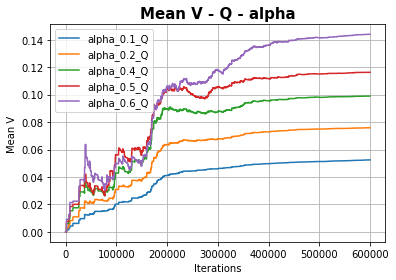

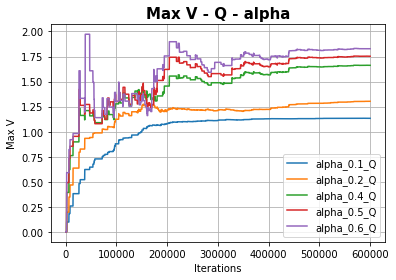

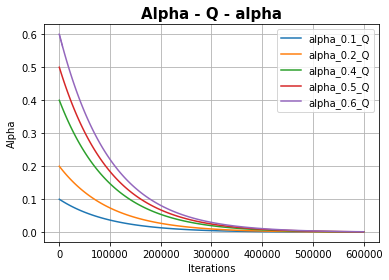

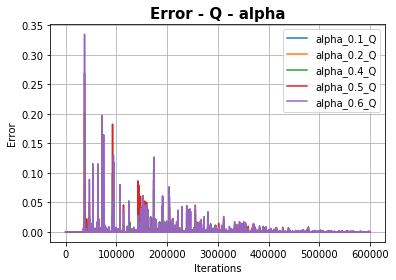

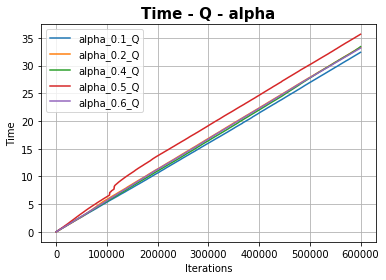

(600000, 50)


In [53]:
results = analyze_param_policy(P_fl_large, R_fl_large, solver_type = "Q", max_iter=600000, epsilon = 1, epsilon_decay = 0.999,
                               param = "alpha", param_range = [0.1, 0.2,0.4, 0.5, 0.6], alpha_decay = 0.99999)

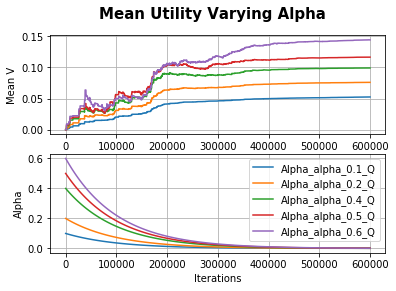

In [54]:
plotIterationGraph(results, "Mean V", "Alpha", "Mean Utility Varying Alpha")

In [86]:
results = analyze_param_policy(P_fl_large, R_fl_large, solver_type = "Q", max_iter=1000000, epsilon = 1, epsilon_decay = 0.999,
                               alpha = 0.6, alpha_decay = 0.99999)

KeyboardInterrupt: 

In [4]:
np.random.seed(252)
ql_large = hiive.mdptoolbox.mdp.QLearning(P_fl_large, R_fl_large, 0.99, n_iter = 1000000 , epsilon = 1, epsilon_decay = 0.99999,
                               alpha = 0.6, alpha_decay = 0.999995, skip_check=True)
test=ql_large.run()

NameError: name 'np' is not defined

(10000, 10)


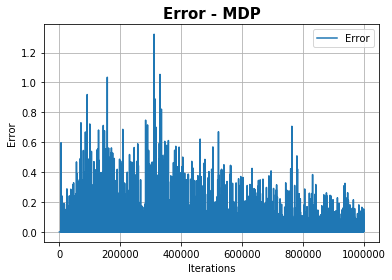

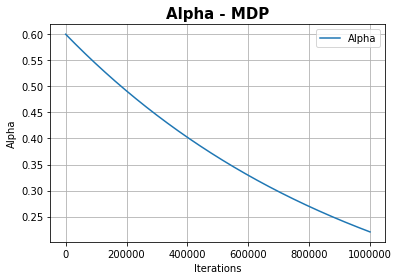

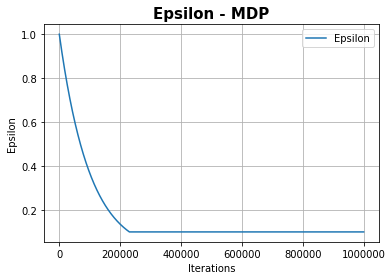

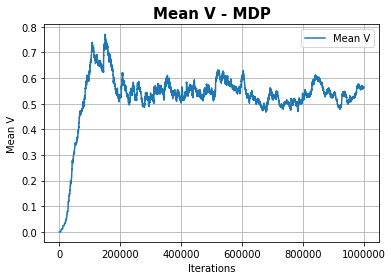

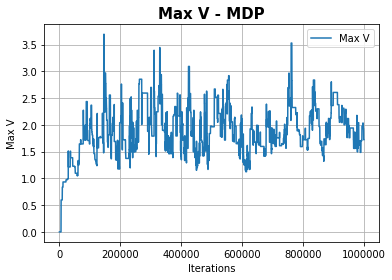

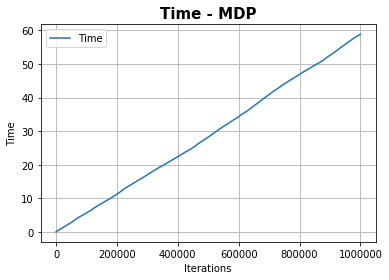

In [105]:
plot_run_stats(ql_large, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])

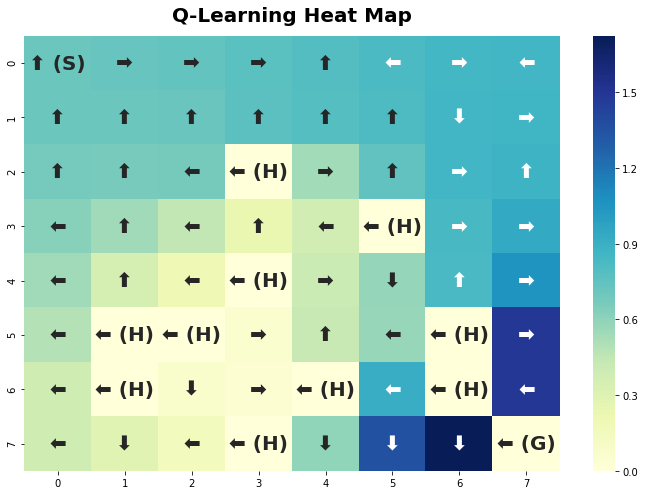

In [103]:
plot_policy_map(ql_large, env_large, "Q-Learning Heat Map")

(10000, 10)


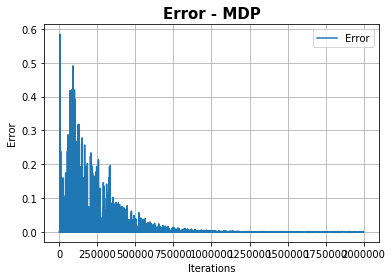

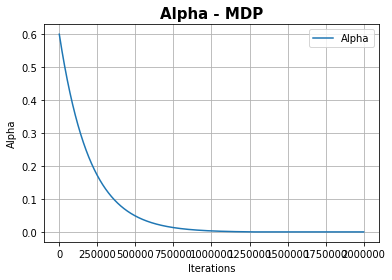

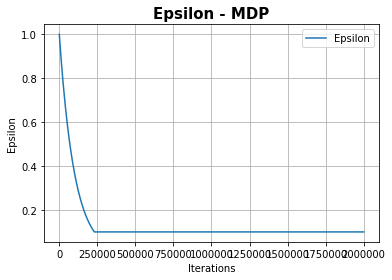

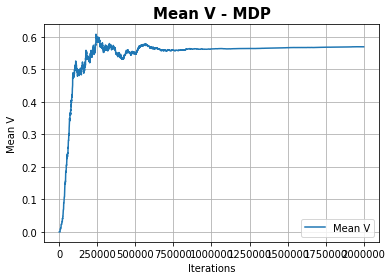

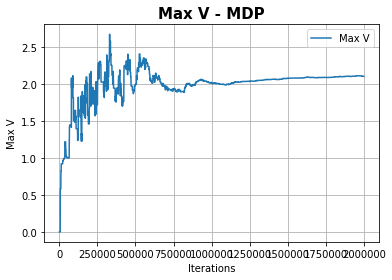

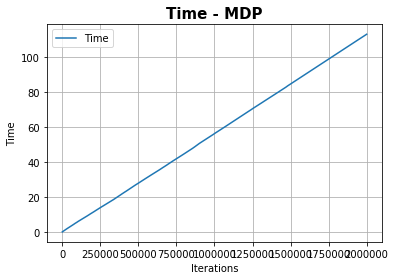

In [106]:
np.random.seed(252)
ql_large = hiive.mdptoolbox.mdp.QLearning(P_fl_large, R_fl_large, 0.99, n_iter = 2000000 , epsilon = 1, epsilon_decay = 0.99999,
                               alpha = 0.6, alpha_decay = 0.999995, skip_check=True)
ql_large.run()
plot_run_stats(ql_large, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])

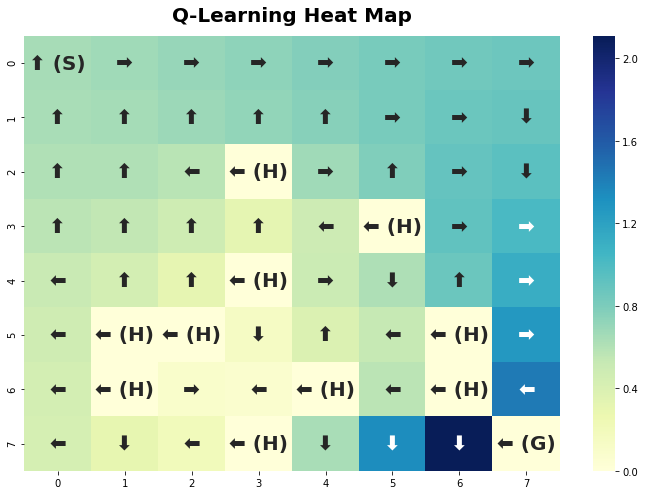

In [107]:
plot_policy_map(ql_large, env_large, "Q-Learning Heat Map")

(10000, 10)


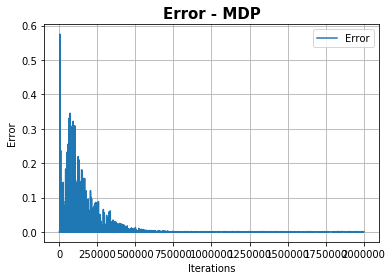

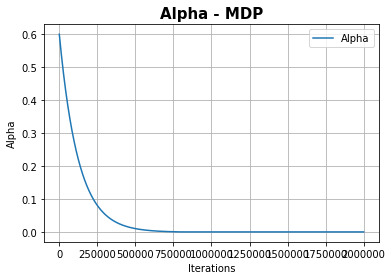

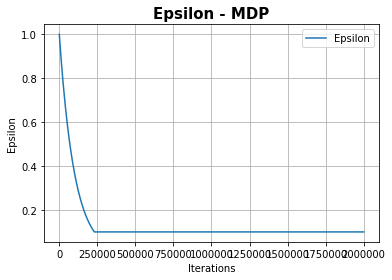

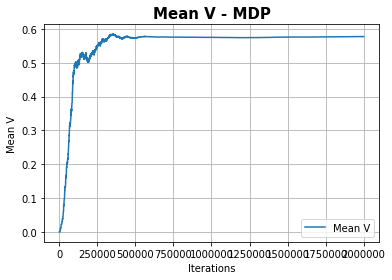

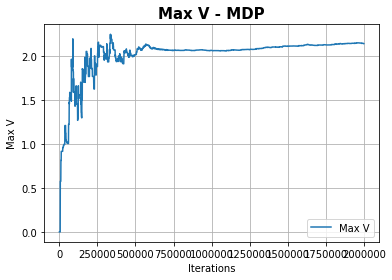

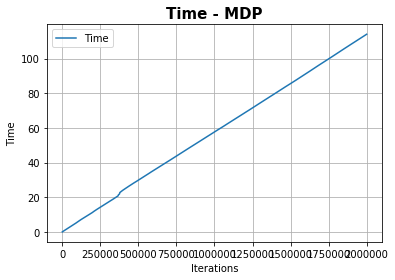

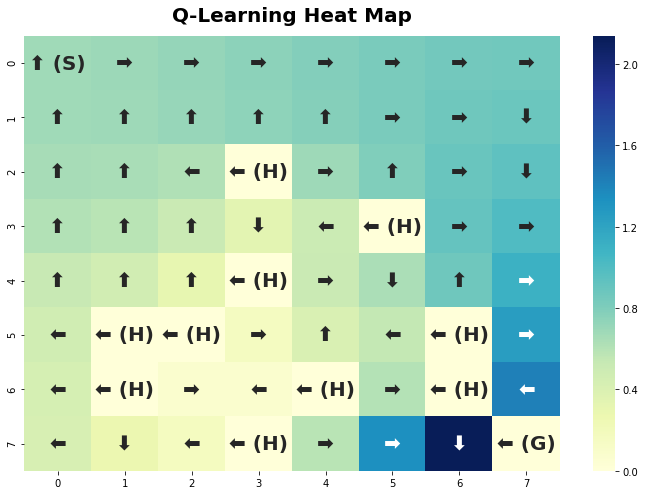

In [108]:
np.random.seed(252)
ql_large = hiive.mdptoolbox.mdp.QLearning(P_fl_large, R_fl_large, 0.99, n_iter = 2000000 , epsilon = 1, epsilon_decay = 0.99999,
                               alpha = 0.6, alpha_decay = 0.999992, skip_check=True)
ql_large.run()
plot_run_stats(ql_large, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
plot_policy_map(ql_large, env_large, "Q-Learning Heat Map")

(10000, 10)


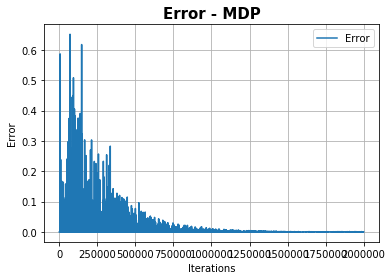

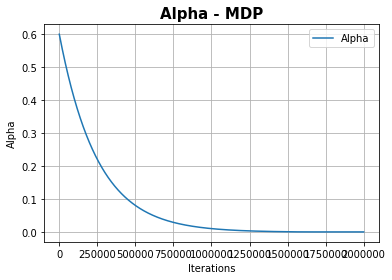

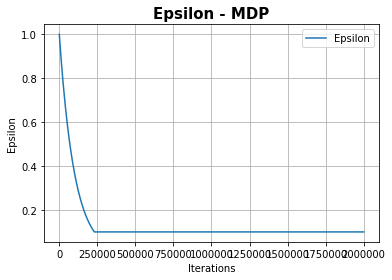

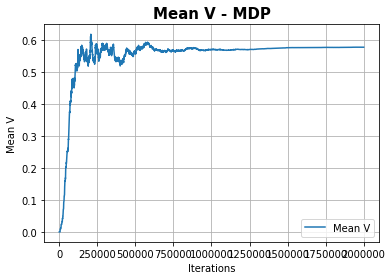

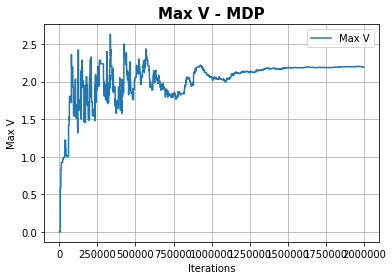

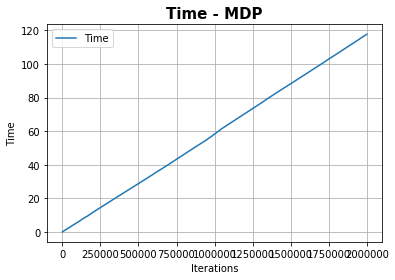

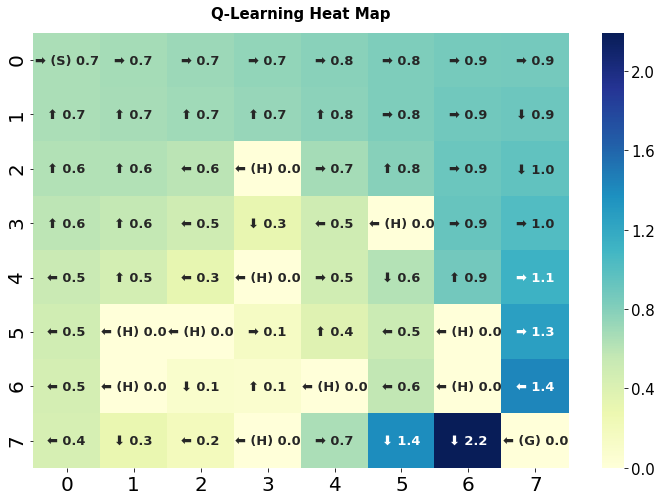

In [30]:
#Selected
np.random.seed(252)
ql_large = hiive.mdptoolbox.mdp.QLearning(P_fl_large, R_fl_large, 0.99, n_iter = 2000000 , epsilon = 1, epsilon_decay = 0.99999,
                               alpha = 0.6, alpha_decay = 0.999996, skip_check=True)
ql_large.run()
plot_run_stats(ql_large, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
plot_policy_map(ql_large, env_large, "Q-Learning Heat Map", showUtility = True)

(10000, 10)


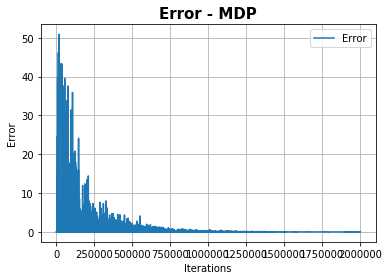

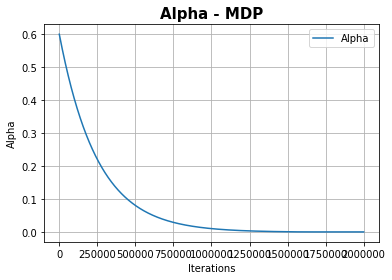

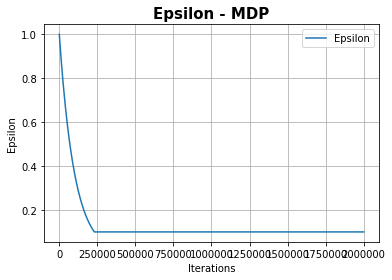

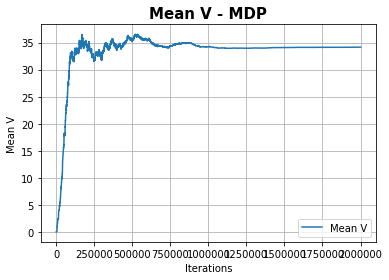

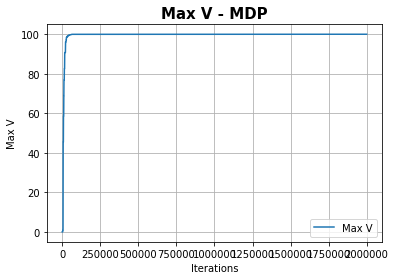

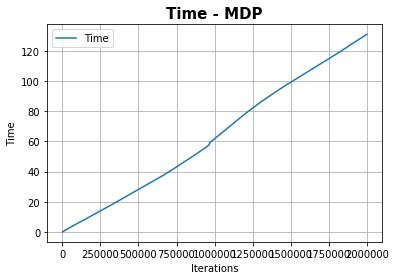

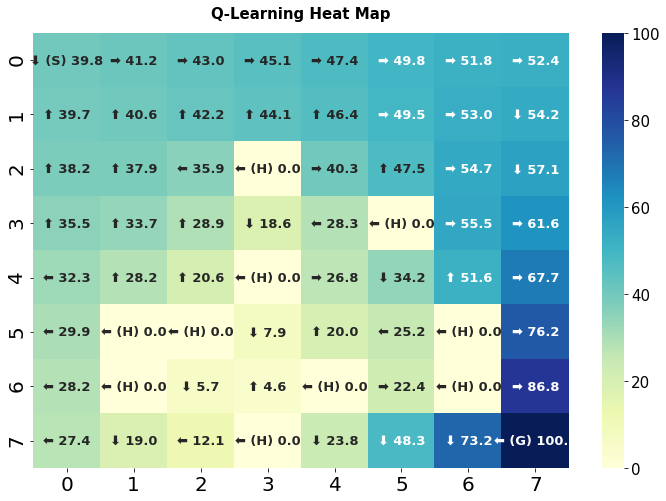

In [520]:
#Selected New
np.random.seed(252)
ql_large = hiive.mdptoolbox.mdp.QLearning(P_fl_large, R_fl_large, 0.99, n_iter = 2000000 , epsilon = 1, epsilon_decay = 0.99999,
                               alpha = 0.6, alpha_decay = 0.999996, skip_check=True)
ql_large.run()
plot_run_stats(ql_large, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
plot_policy_map(ql_large, env_large, "Q-Learning Heat Map", showUtility = True)

(10000, 10)


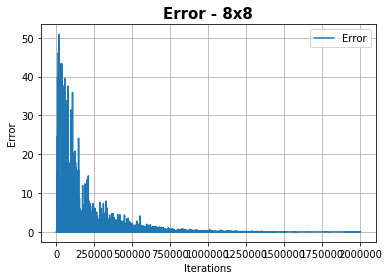

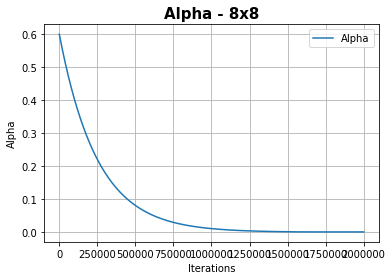

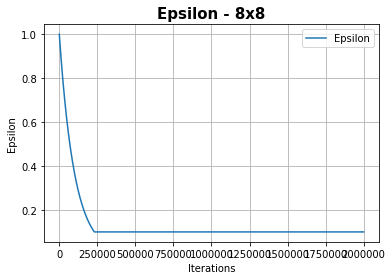

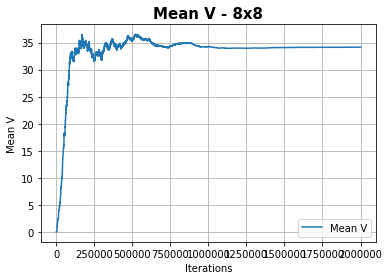

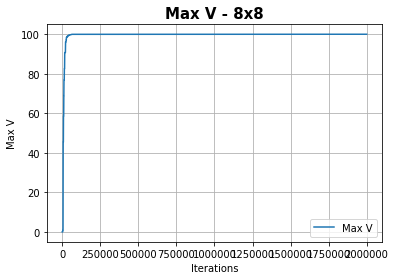

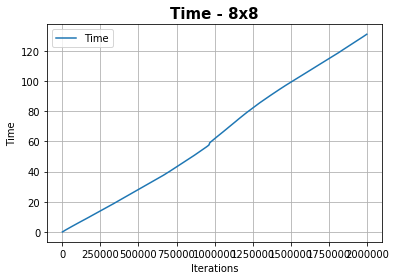

In [560]:
plot_run_stats(ql_large, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"], title = "8x8")

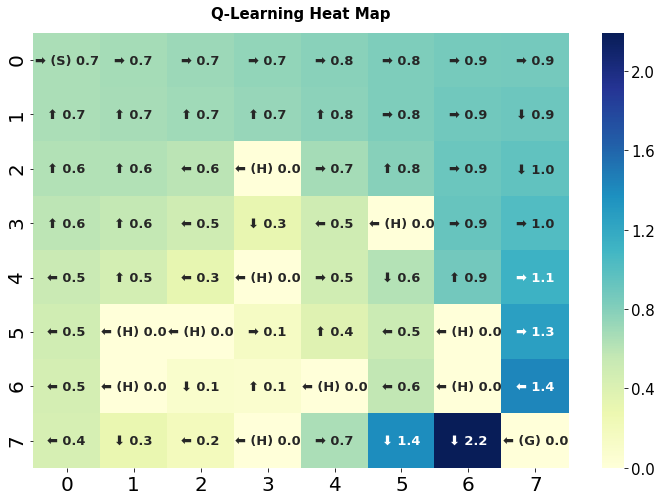

In [31]:
plot_policy_map(ql_large, env_large, "Q-Learning Heat Map", showUtility = True)

(10000, 10)


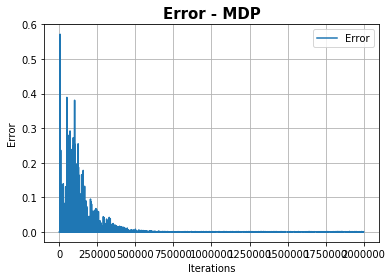

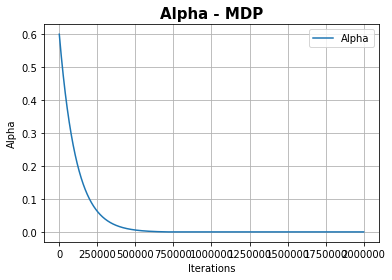

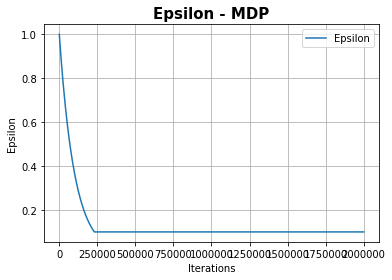

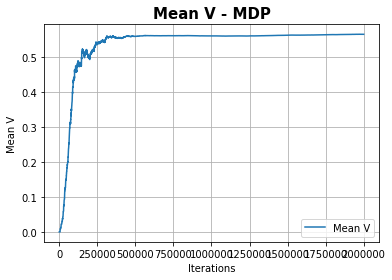

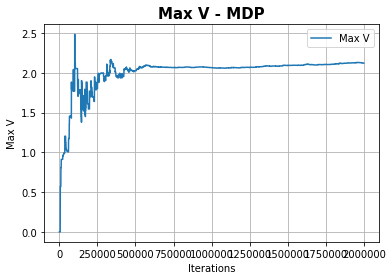

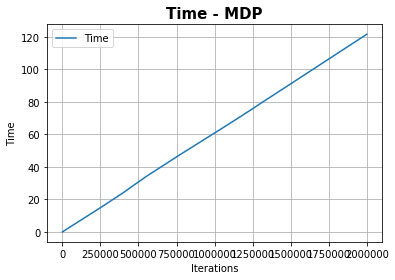

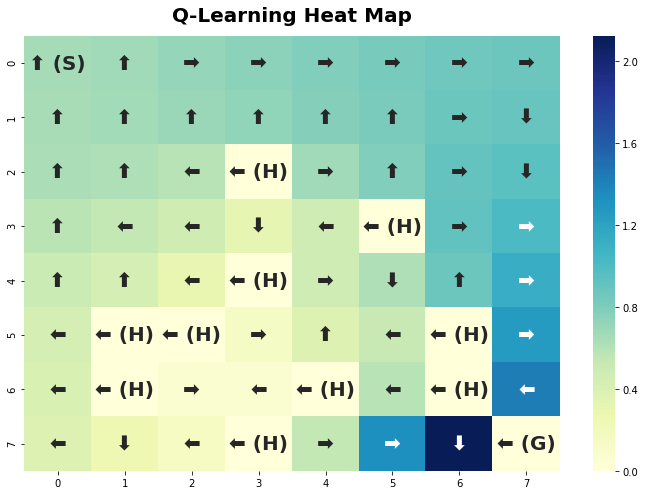

In [110]:
np.random.seed(252)
ql_large = hiive.mdptoolbox.mdp.QLearning(P_fl_large, R_fl_large, 0.99, n_iter = 2000000 , epsilon = 1, epsilon_decay = 0.99999,
                               alpha = 0.6, alpha_decay = 0.999991, skip_check=True)
ql_large.run()
plot_run_stats(ql_large, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
plot_policy_map(ql_large, env_large, "Q-Learning Heat Map")

(10000, 10)


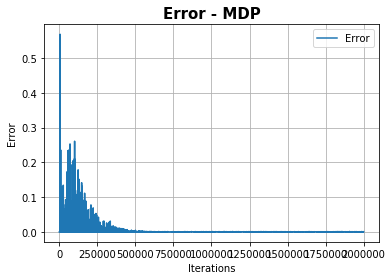

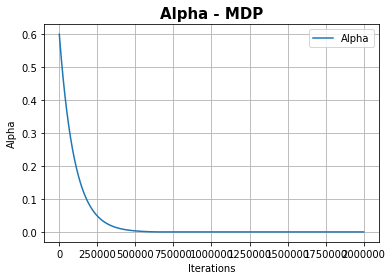

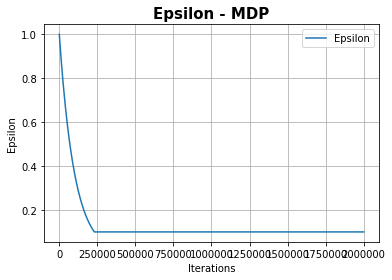

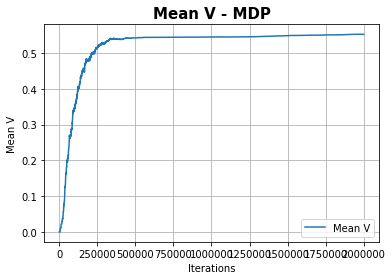

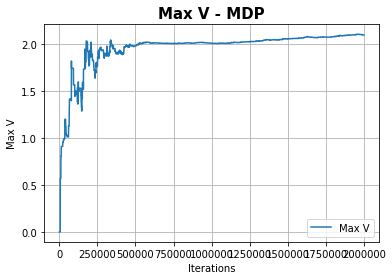

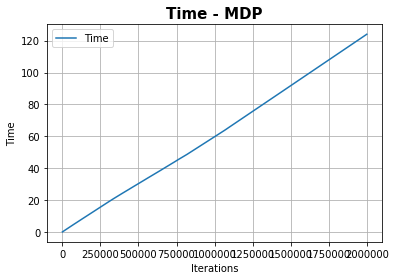

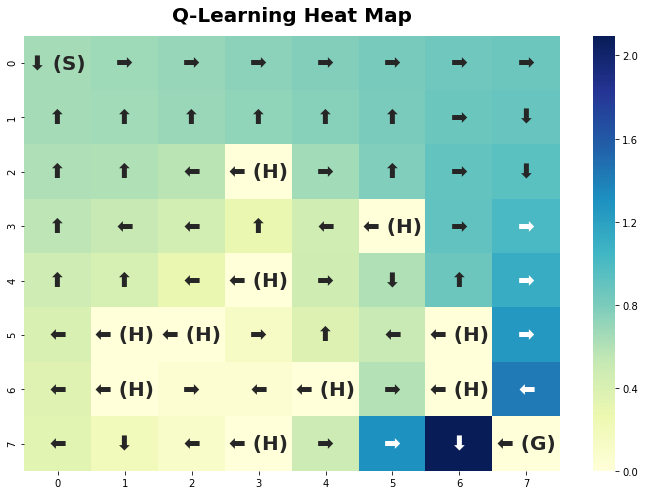

In [111]:
np.random.seed(252)
ql_large = hiive.mdptoolbox.mdp.QLearning(P_fl_large, R_fl_large, 0.99, n_iter = 2000000 , epsilon = 1, epsilon_decay = 0.99999,
                               alpha = 0.6, alpha_decay = 0.99999, skip_check=True)
ql_large.run()
plot_run_stats(ql_large, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
plot_policy_map(ql_large, env_large, "Q-Learning Heat Map")

In [ ]:
pi_fm = hiive.mdptoolbox.mdp.PolicyIteration(P_fm, R_fm, gamma = 0.99, max_iter=1000)
pi_fm.run()
print(pi_fm.policy)
Counter(pi_fm.policy)

# Forest Management

In [116]:
S=500
P_fm, R_fm, = hiive.mdptoolbox.example.forest(S=S, p=0.2, r1 = 5, r2 = 10)

(20, 42)


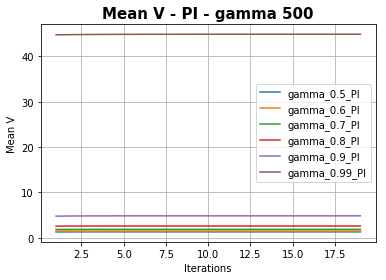

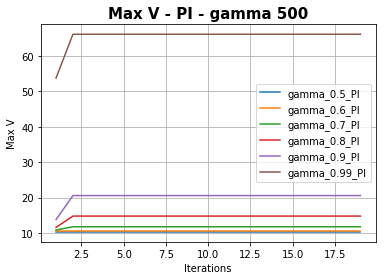

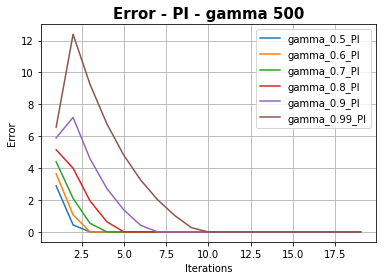

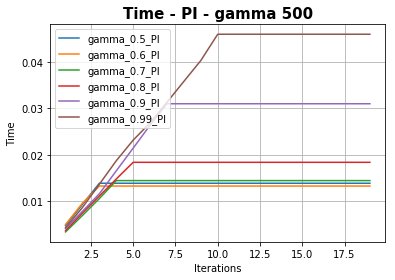

(20, 42)


In [60]:
results = analyze_param_policy(P_fm, R_fm,size = str(S), max_iter = 20, param_range = [0.5,0.6,0.7,0.8, 0.9, 0.99])

(20, 7)


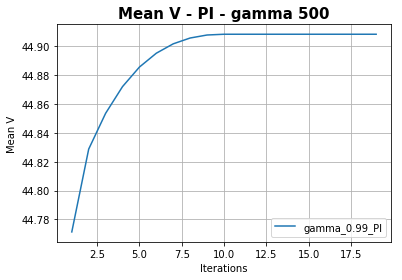

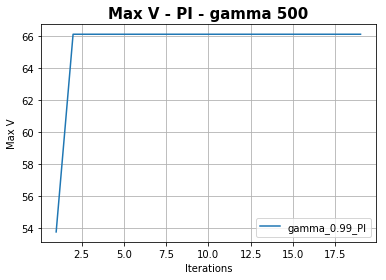

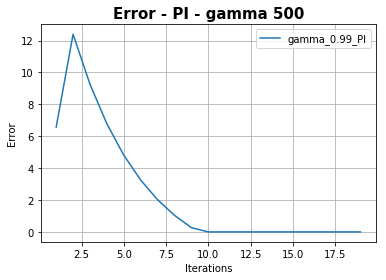

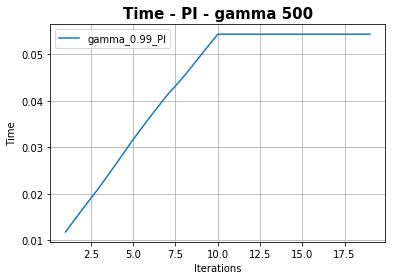

(20, 7)


In [61]:
results = analyze_param_policy(P_fm, R_fm,size = str(S), max_iter = 20, param_range = [0.99])

(20, 7)


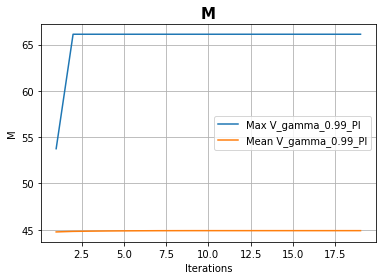

TypeError: Empty 'DataFrame': no numeric data to plot

In [62]:
plot_param(results,params ="Mean V_gamma_0.99_PI")

In [ ]:
pi_fm = hiive.mdptoolbox.mdp.PolicyIteration(P_fm, R_fm, gamma = 0.99, max_iter=100)
pi_fm.run()
print(pi_fm.policy)
Counter(pi_fm.policy)

In [ ]:
pi_fm.V

In [ ]:
def size_vs_policy():
    li = []
    for i in range(15, 501):
        
        P_fm, R_fm, = hiive.mdptoolbox.example.forest(S=i, p=0.2, r1 = 10, r2 = 20)

        pi_fm = hiive.mdptoolbox.mdp.PolicyIteration(P_fm, R_fm, gamma = 0.99, max_iter=1000)
        pi_fm.run()
        #print(pi_fm.policy)
        li.append(Counter(pi_fm.policy))
    #print(li)
    df = pd.DataFrame(li, index = range(15,501))
    #df[1] = df[0]-1
    df.plot()
    plt.title("Number of Lagging 0s in OP")
    plt.grid(True)
    #return df

    
def gamma_vs_policy():
    li = []
    range_gamma = np.linspace(0.01, 0.9, num=100).tolist()
    range_gamma_1 = np.linspace(0.9, 0.999999999, num=100).tolist()
    range_gamma.extend(range_gamma_1)

    #print(range_gamma)
    for i in range_gamma:
        
        P_fm, R_fm, = hiive.mdptoolbox.example.forest(S=500, p=0.2, r1 = 10, r2 = 20)

        pi_fm = hiive.mdptoolbox.mdp.PolicyIteration(P_fm, R_fm, gamma = i, max_iter=1000)
        pi_fm.run()
        #print(pi_fm.policy)
        li.append(Counter(pi_fm.policy))
    #print(li)
    df = pd.DataFrame(li, index =range_gamma)
    df[0] = df[0]-1
    df[[0]].plot()
    plt.title("Number of Lagging 0s in OP")
    plt.grid(True)
    

In [ ]:
size_vs_policy()

In [ ]:
gamma_vs_policy()

In [ ]:
pi_fm = hiive.mdptoolbox.mdp.PolicyIteration(P_fm, R_fm, gamma = 0.99, max_iter=1000)
pi_fm.run()
print(pi_fm.policy)
Counter(pi_fm.policy)

In [ ]:
from collections import Counter
P_fm, R_fm, = hiive.mdptoolbox.example.forest(S =500, p = 0.01,r1 = 10,r2= 20)#S=15, p=0.1, r1 = 3, r2 = 2)

pi_fm = hiive.mdptoolbox.mdp.PolicyIteration(P_fm, R_fm, gamma = 0.99, max_iter=1000)
pi_fm.run()
print(pi_fm.policy)
Counter(pi_fm.policy)

In [ ]:
from collections import Counter
P_fm, R_fm, = hiive.mdptoolbox.example.forest(S =15, p = 0.8,r1 = 5,r2= 10)#S=15, p=0.1, r1 = 3, r2 = 2)

pi_fm = hiive.mdptoolbox.mdp.PolicyIteration(P_fm, R_fm, gamma = 0.99, max_iter=1000)
pi_fm.run()
print(pi_fm.policy)
Counter(pi_fm.policy)

In [117]:

vi_fm = hiive.mdptoolbox.mdp.ValueIteration(P_fm, R_fm, gamma = 0.99, max_iter=60)
vi_fm.run()
print(vi_fm.policy)

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
print(vi_fm.V)

(1000, 28)


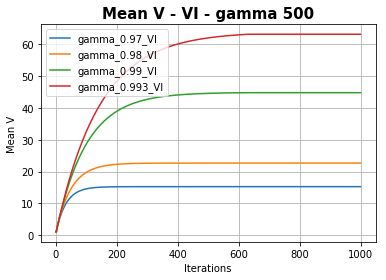

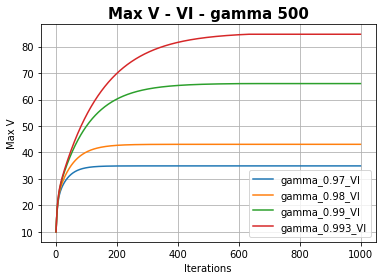

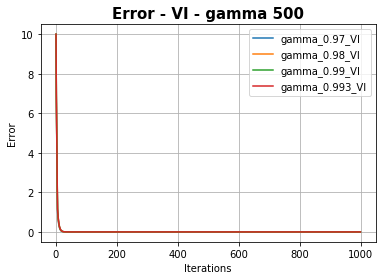

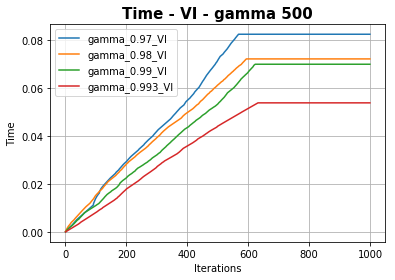

(1000, 28)


In [64]:
results = analyze_param_policy(P_fm, R_fm, solver_type = "VI", size = str(S), max_iter = 1000,epsilon_V = 1e-60)

In [113]:
results = analyze_param_policy(P_fm, R_fm, solver_type = "VI", size = str(S), max_iter = 1000,epsilon_V = 1e-60)

NameError: name 'P_fm' is not defined

(500, 56)


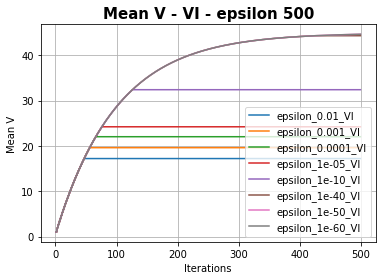

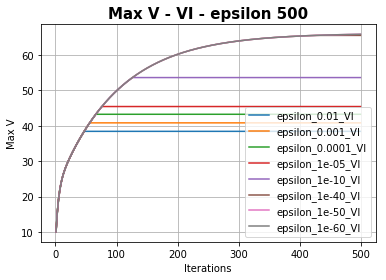

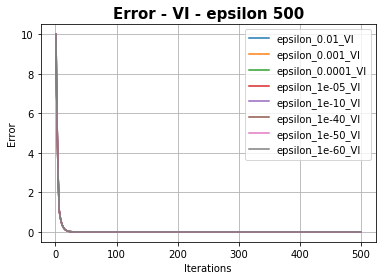

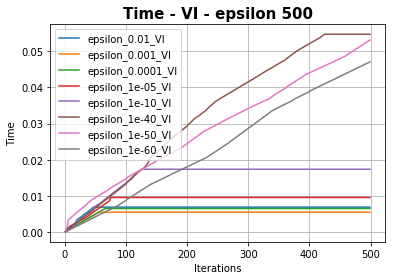

(500, 56)


In [63]:
results = analyze_param_policy(P_fm, R_fm, solver_type = "VI", param = "epsilon", param_range = [0.01,0.001,0.0001,0.00001,1e-10, 1e-40,1e-50, 1e-60], size = str(S), max_iter = 500)



In [120]:
vi_fm = hiive.mdptoolbox.mdp.ValueIteration(P_fm, R_fm, gamma = 0.99, max_iter=1000, epsilon=10e-100)
vi_fm.run()
print(vi_fm.policy)
Counter(vi_fm.policy)
print(vi_fm.V)

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Text(0.5,1,'Utility Values for States')

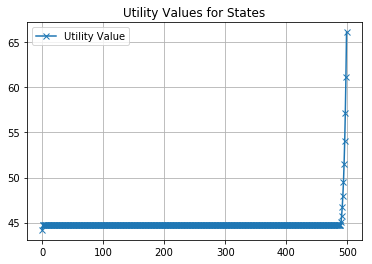

In [121]:
df_values = pd.DataFrame(list(vi_fm.V), columns= ["Utility Value"])
df_values.plot(style = "-x")
plt.grid(True)
plt.title("Utility Values for States")

(500000, 40)


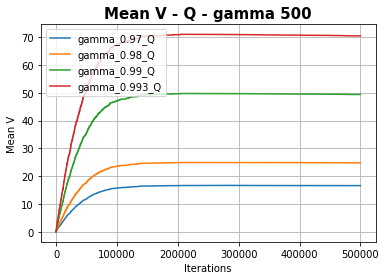

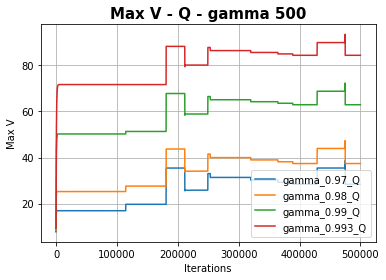

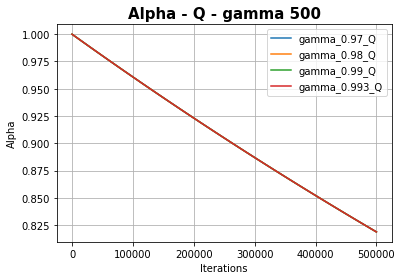

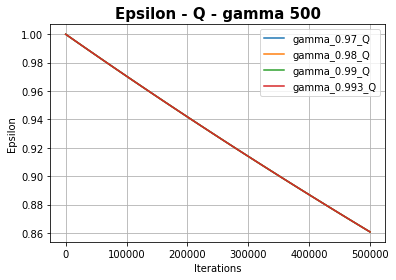

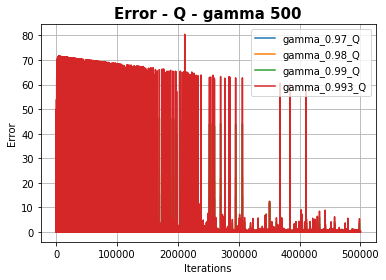

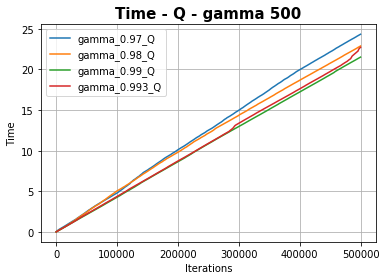

(500000, 40)


In [79]:
results = analyze_param_policy(P_fm, R_fm, size = str(S), solver_type = "Q", max_iter=500000, epsilon = 1, epsilon_decay = 0.9999997,
                               alpha = 1, alpha_decay = 0.9999996)

(500000, 60)


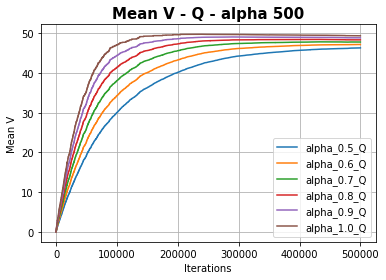

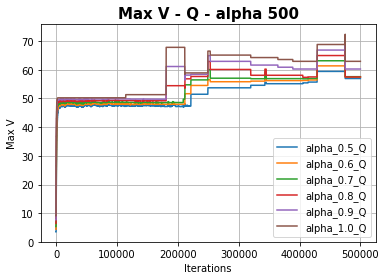

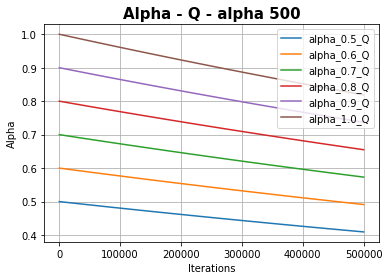

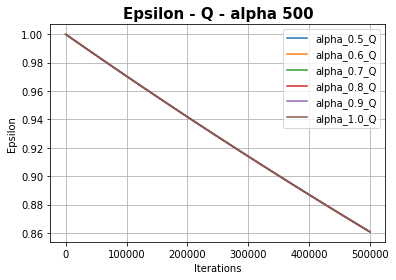

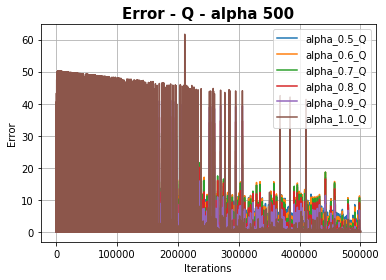

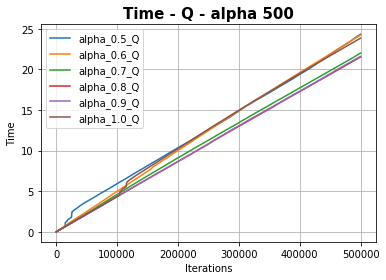

(500000, 60)


In [80]:
results = analyze_param_policy(P_fm, R_fm, size = str(S), solver_type = "Q", max_iter=500000, epsilon = 1, epsilon_decay = 0.9999997,
                              param = "alpha", param_range = [0.5, 0.6,0.7,0.8,0.9,1.0], alpha = 1, alpha_decay = 0.9999996)

(500000, 60)


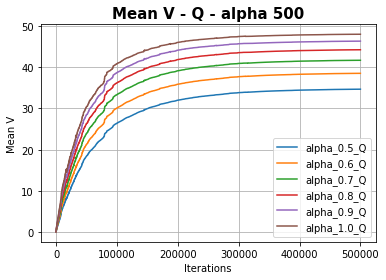

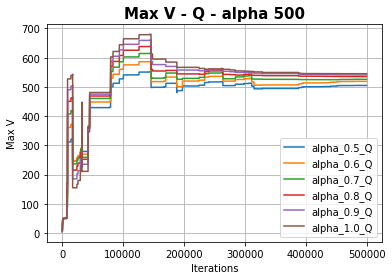

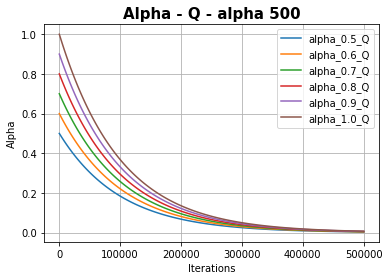

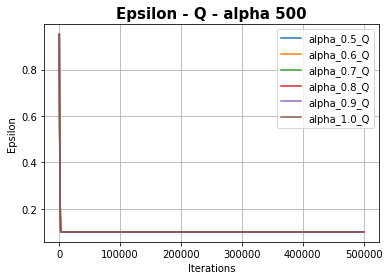

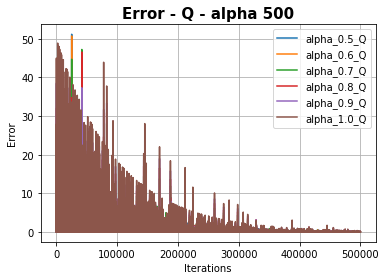

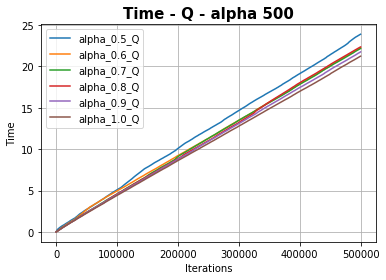

(500000, 60)


In [605]:
results = analyze_param_policy(P_fm, R_fm, size = str(S), solver_type = "Q", max_iter=500000, epsilon = 1, epsilon_decay = 0.999,
                               param = "alpha", param_range = [0.5, 0.6,0.7,0.8,0.9,1.0], alpha_decay = 0.99999)

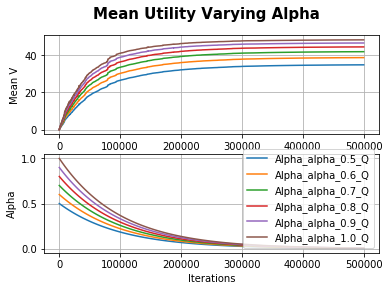

In [606]:
plotIterationGraph(results, "Mean V", "Alpha", "Mean Utility Varying Alpha")

(5000000, 50)


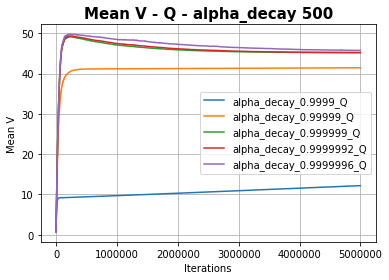

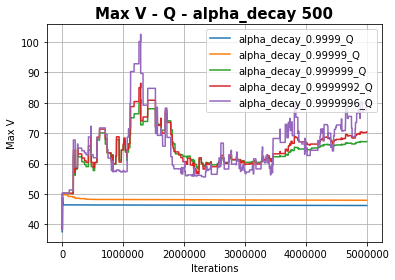

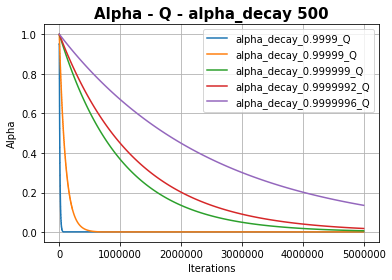

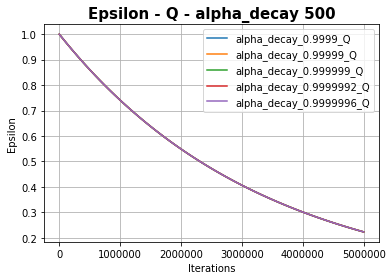

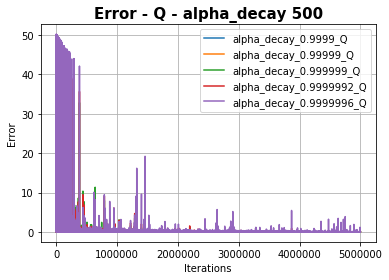

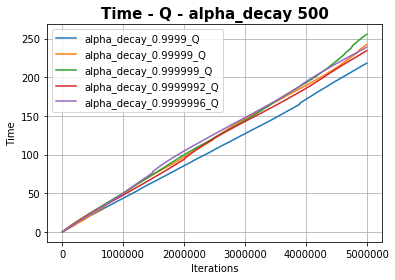

(5000000, 50)


In [81]:
results_alpha_decay = analyze_param_policy(P_fm, R_fm, size = str(S), solver_type = "Q", max_iter=5000000, epsilon = 1, epsilon_decay = 0.9999997,
                               param = "alpha_decay", param_range = [0.9999, 0.99999, 0.999999, 0.9999992, 0.9999996], alpha = 1)


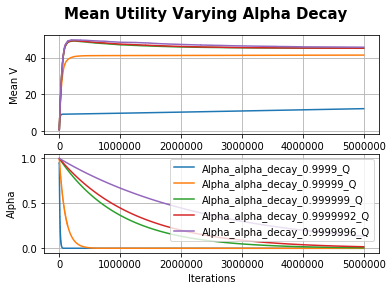

In [82]:
plotIterationGraph(results_alpha_decay, "Mean V", "Alpha", "Mean Utility Varying Alpha Decay")

(5000000, 50)


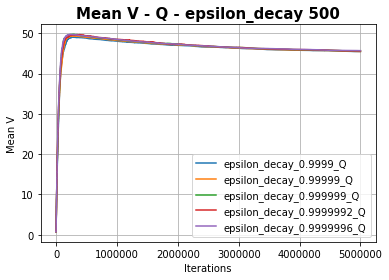

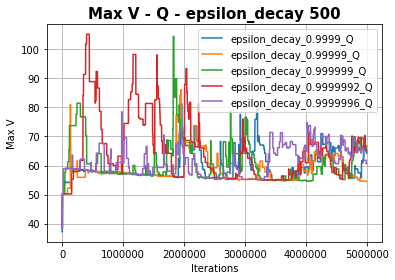

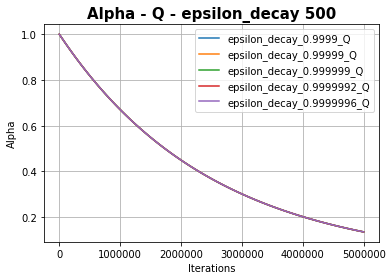

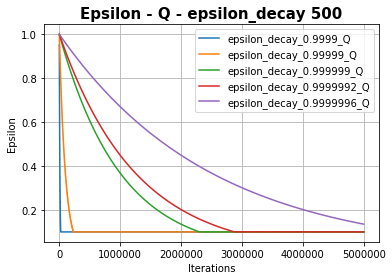

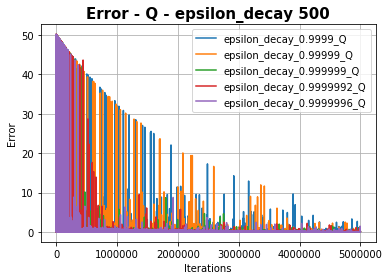

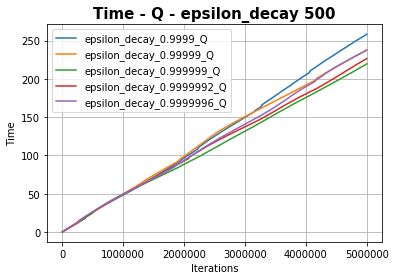

(5000000, 50)


In [84]:
results_epsilon_decay = analyze_param_policy(P_fm, R_fm, size = str(S), solver_type = "Q", max_iter=5000000, epsilon = 1, alpha_decay = 0.9999996,
                               param = "epsilon_decay", param_range = [0.9999, 0.99999, 0.999999, 0.9999992, 0.9999996], alpha = 1)


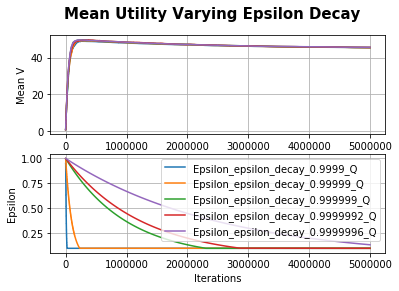

In [93]:
plotIterationGraph(results_epsilon_decay, "Mean V", "Epsilon", "Mean Utility Varying Epsilon Decay")

(5000000, 50)


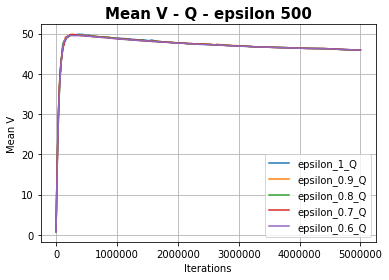

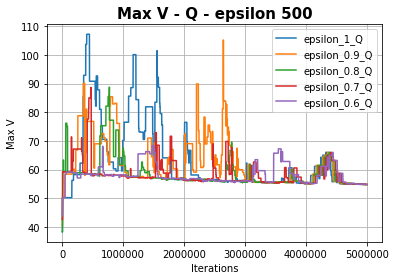

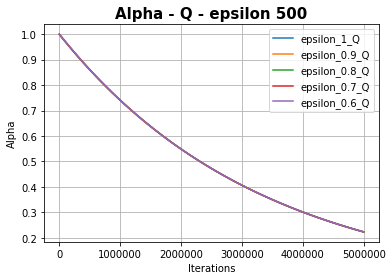

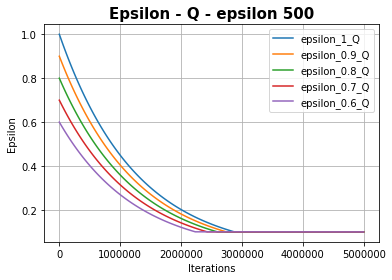

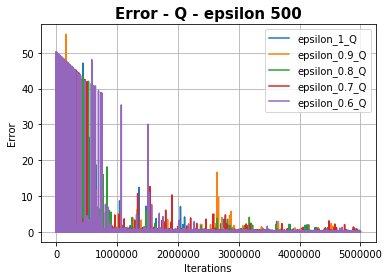

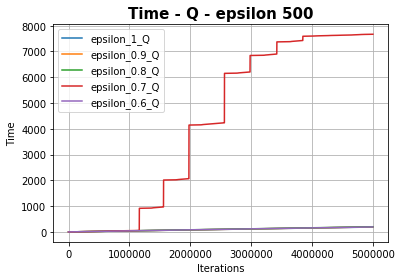

(5000000, 50)


In [95]:
results = analyze_param_policy(P_fm, R_fm, size = str(S), solver_type = "Q", max_iter=5000000, epsilon_decay = 0.9999992, alpha_decay = 0.9999997,
                               param = "epsilon", param_range = [1, 0.9, 0.8, 0.7, 0.6], alpha = 1)

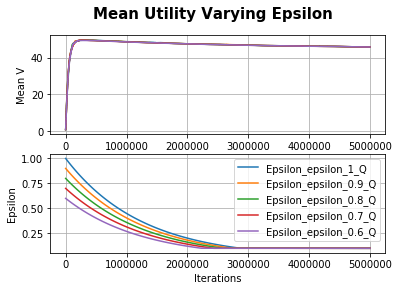

In [96]:
plotIterationGraph(results, "Mean V", "Epsilon", "Mean Utility Varying Epsilon")

(500000, 40)


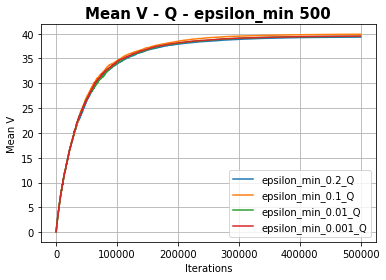

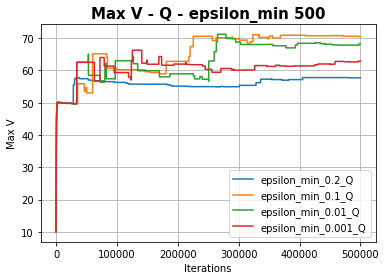

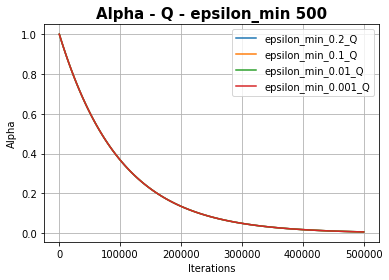

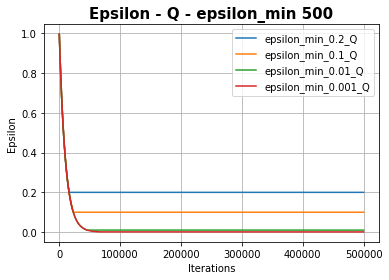

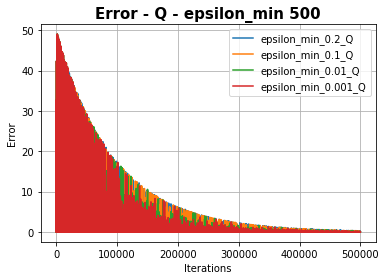

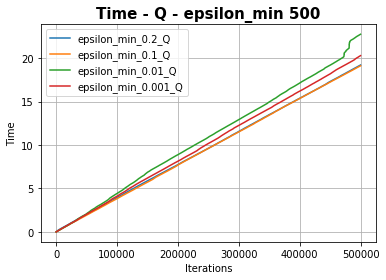

(500000, 40)


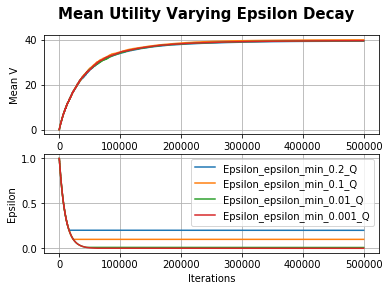

In [88]:
results = analyze_param_policy(P_fm, R_fm, size = str(S), solver_type = "Q", max_iter=500000, epsilon_decay = 0.9999, alpha_decay = 0.99999, epsilon =1,
                               param = "epsilon_min", param_range = [0.2, 0.1,0.01,0.001], alpha = 1)


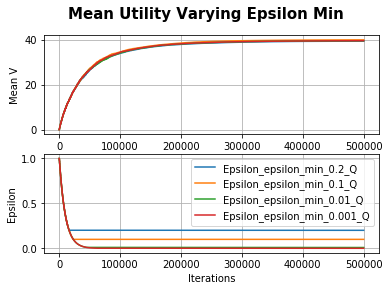

In [94]:
plotIterationGraph(results, "Mean V", "Epsilon", "Mean Utility Varying Epsilon Min")

(10000, 10)


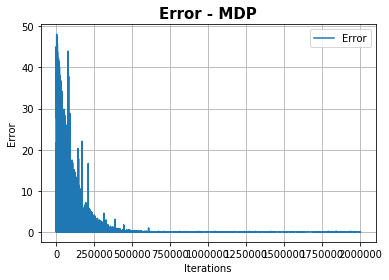

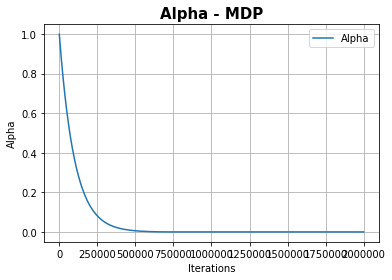

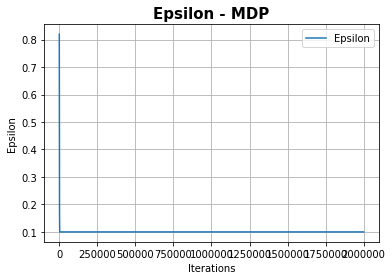

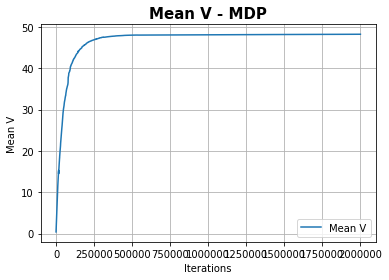

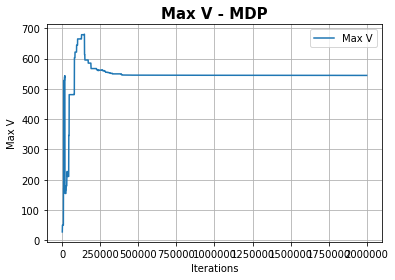

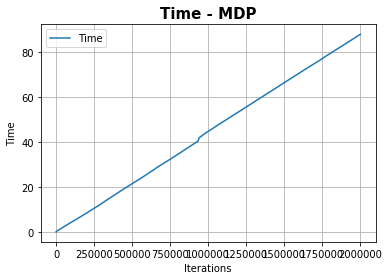

ValueError: cannot reshape array of size 500 into shape (8,8)

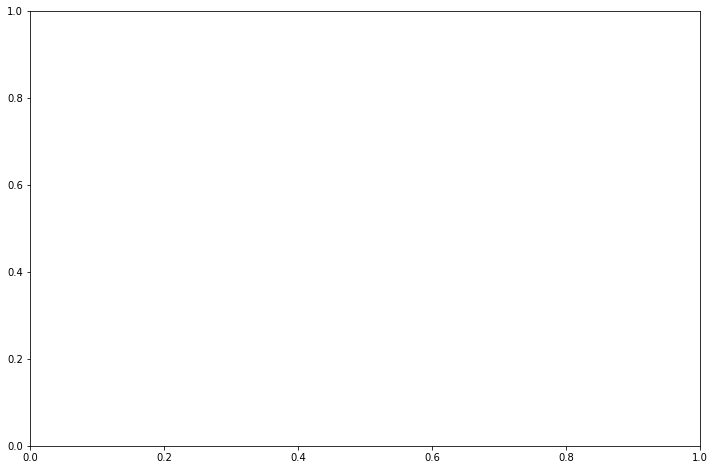

In [613]:
np.random.seed(252)
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm, R_fm, 0.99, n_iter = 2000000 , epsilon = 1, epsilon_decay = 0.999,
                               alpha = 1, alpha_decay = 0.99999, skip_check=True)
ql_fm.run()
plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

In [614]:
print(ql_fm.policy)
Counter(ql_fm.policy)

(0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

Counter({0: 371, 1: 129})

(10000, 10)


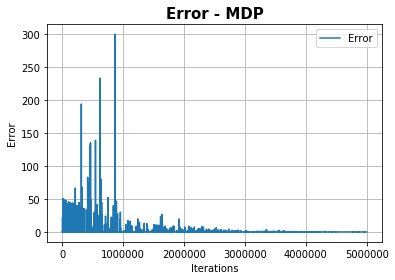

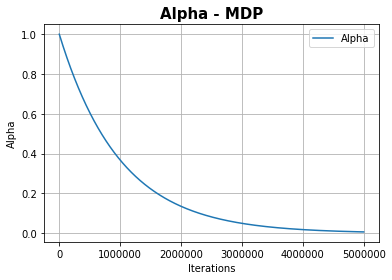

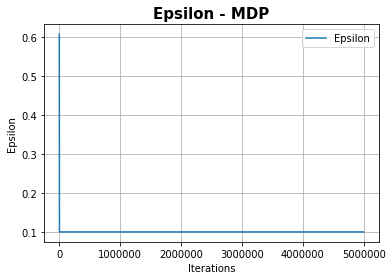

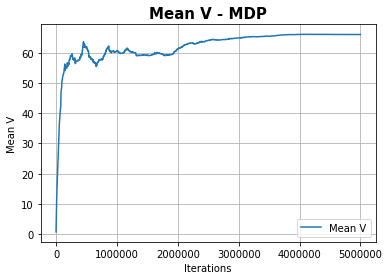

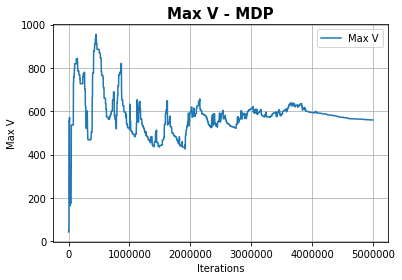

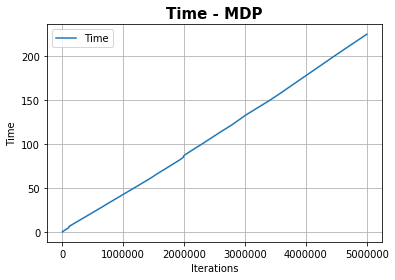

(0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 

Counter({0: 282, 1: 218})

In [615]:
np.random.seed(252)
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm, R_fm, 0.99, n_iter = 5000000 , epsilon = 1, epsilon_decay = 0.999,
                               alpha = 1, alpha_decay = 0.999999, skip_check=True)
ql_fm.run()
plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

(10000, 10)


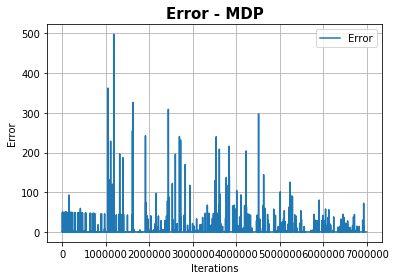

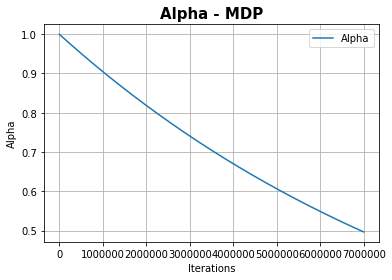

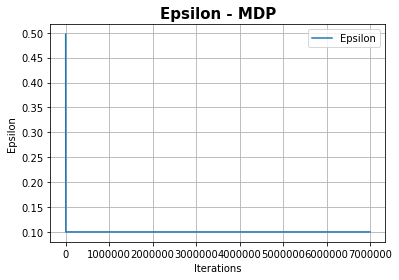

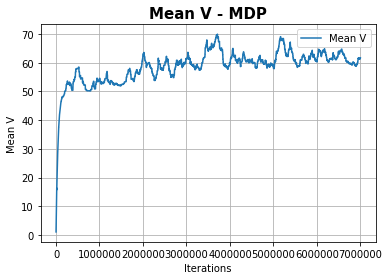

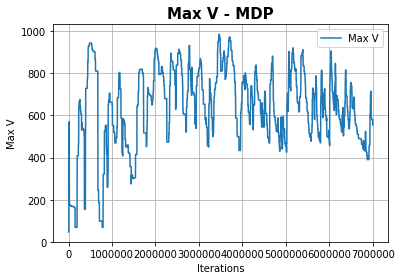

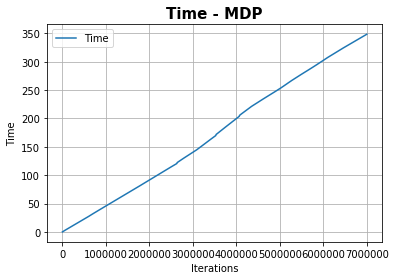

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 

Counter({0: 30, 1: 470})

In [616]:
np.random.seed(252)
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm, R_fm, 0.99, n_iter = 7000000 , epsilon = 1, epsilon_decay = 0.999,
                               alpha = 1, alpha_decay = 0.9999999, skip_check=True)
ql_fm.run()
plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

(10000, 10)


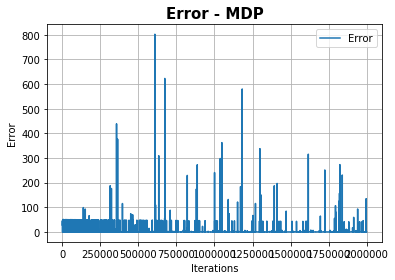

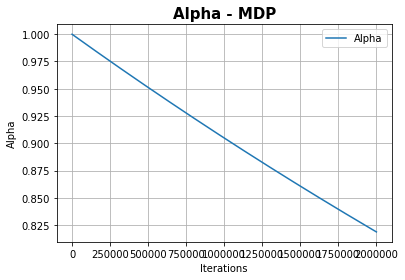

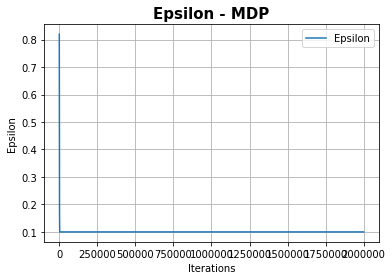

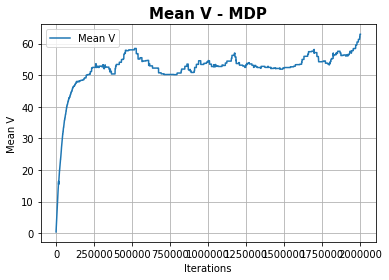

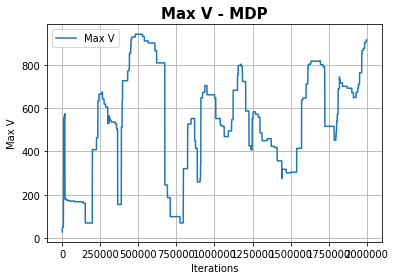

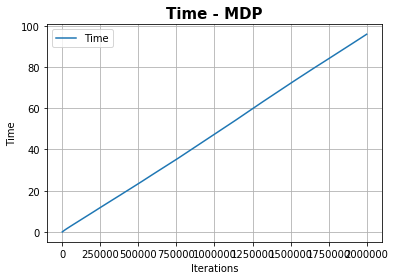

(0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 

Counter({0: 110, 1: 390})

In [617]:
np.random.seed(252)
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm, R_fm, 0.99, n_iter = 2000000 , epsilon = 1, epsilon_decay = 0.999,
                               alpha = 1, alpha_decay = 0.9999999, skip_check=True)
ql_fm.run()
plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

(10000, 10)


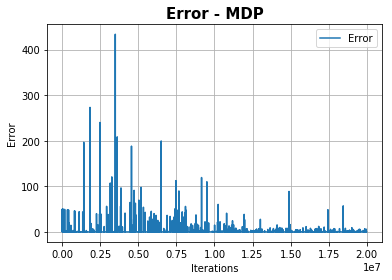

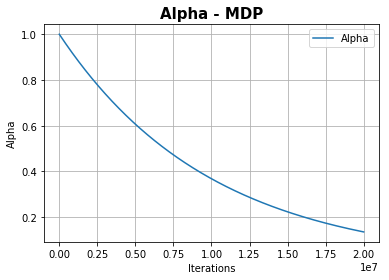

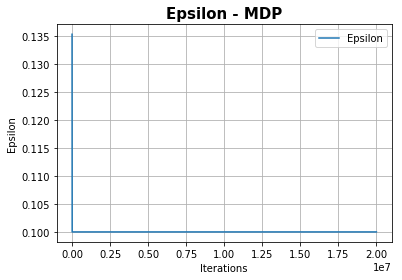

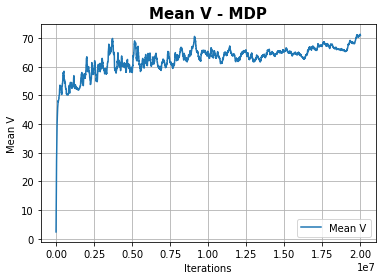

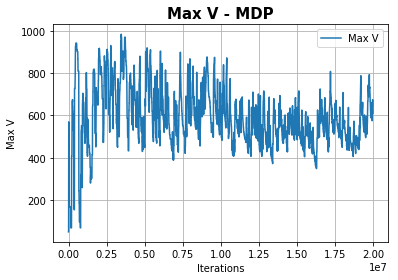

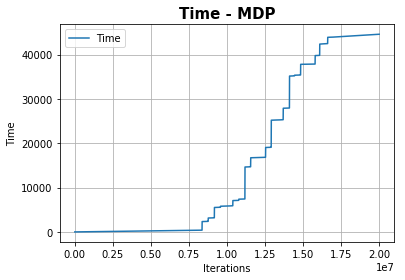

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Counter({0: 27, 1: 473})

In [618]:
np.random.seed(252)
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm, R_fm, 0.99, n_iter = 20000000 , epsilon = 1, epsilon_decay = 0.999,
                               alpha = 1, alpha_decay = 0.9999999, skip_check=True)
ql_fm.run()
plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

(10000, 10)


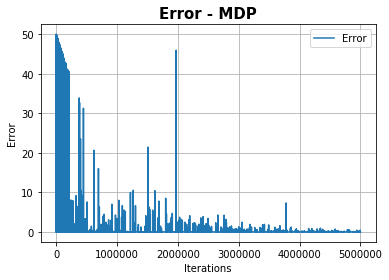

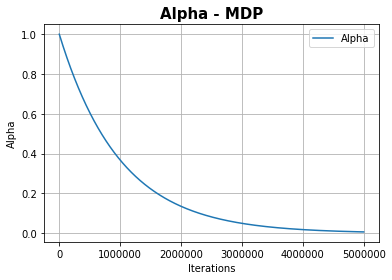

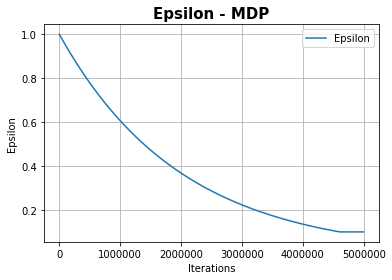

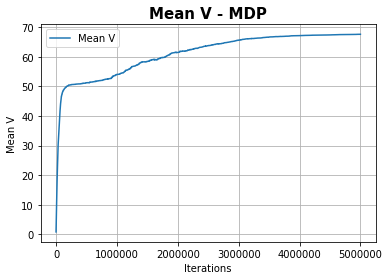

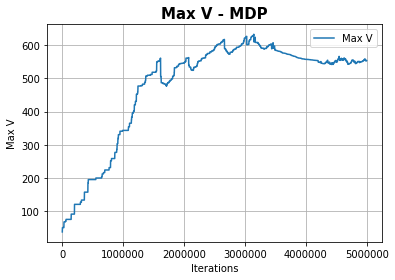

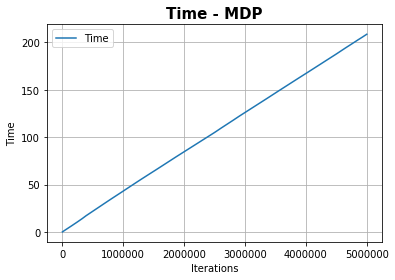

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Counter({0: 26, 1: 474})

In [627]:
np.random.seed(252)
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm, R_fm, 0.99, n_iter = 5000000 , epsilon = 1, epsilon_decay = 0.9999995,
                               alpha = 1, alpha_decay = 0.999999, skip_check=True)
ql_fm.run()
plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

In [ ]:
np.random.seed(252)
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm, R_fm, 0.99, n_iter = 40000000 , epsilon = 1, epsilon_decay = 0.99999,
                               alpha = 1, alpha_decay = 0.9999999999, skip_check=True)
ql_fm.run()
plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

In [ ]:
S=100
P_fm_small, R_fm_small, = hiive.mdptoolbox.example.forest(S=S, p=0.2, r1 = 5, r2 = 10)

In [109]:
S=15
P_fm_small, R_fm_small, = hiive.mdptoolbox.example.forest(S=S, p=0.2, r1 = 5, r2 = 10)

(15, 28)


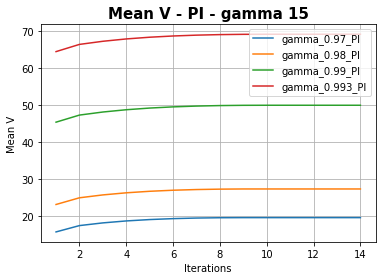

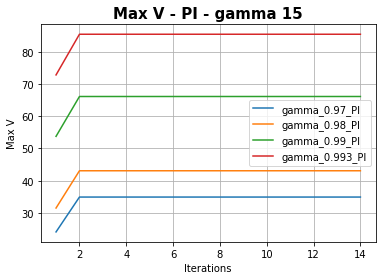

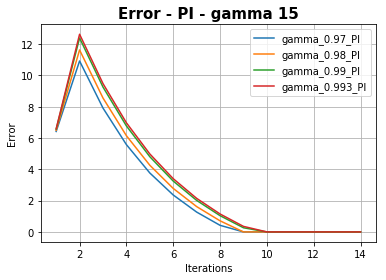

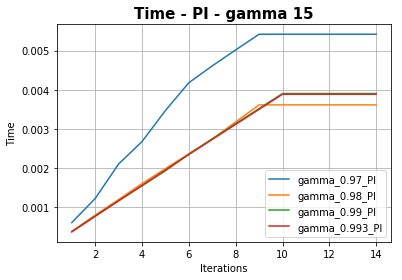

(15, 28)


In [110]:
results = analyze_param_policy(P_fm_small, R_fm_small, size = str(S), max_iter= 15)

(1000, 28)


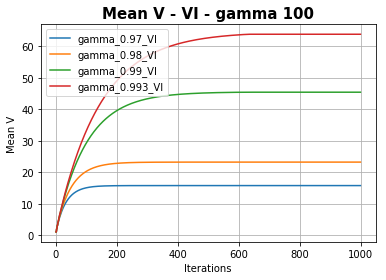

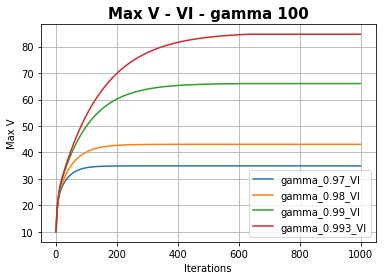

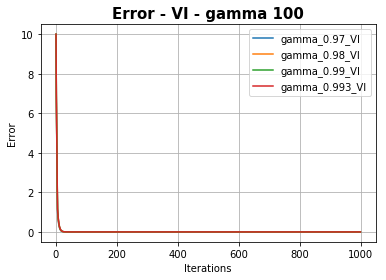

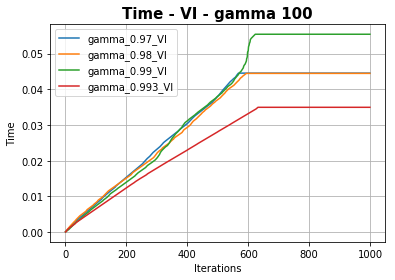

(1000, 28)


In [108]:
results = analyze_param_policy(P_fm_small, R_fm_small, size = str(S), max_iter= 1000, solver_type="VI", epsilon_V = 1e-60)

In [195]:
pi_fm = hiive.mdptoolbox.mdp.PolicyIteration(P_fm_small, R_fm_small, gamma = 0.99, max_iter=1000)
pi_fm.run()
print(pi_fm.policy)
Counter(pi_fm.policy)

(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Counter({0: 11, 1: 4})

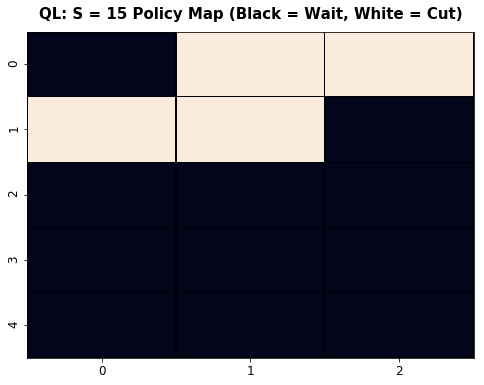

In [197]:
plot_policy_map_fm(pi_fm, title = "QL: S = 15 Policy Map (Black = Wait, White = Cut)", dimensions=(5,3))

(10000, 10)


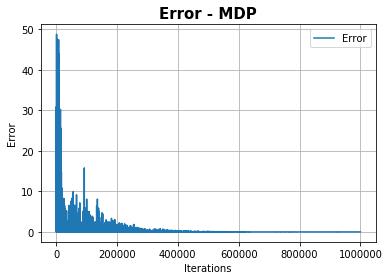

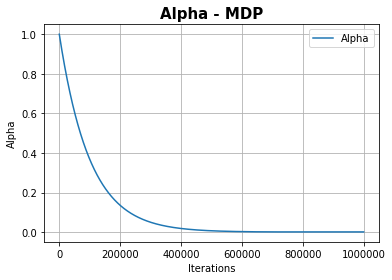

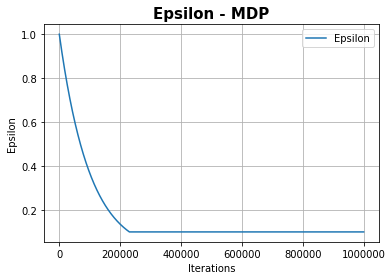

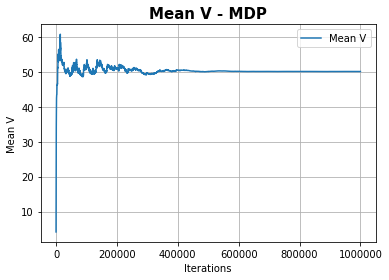

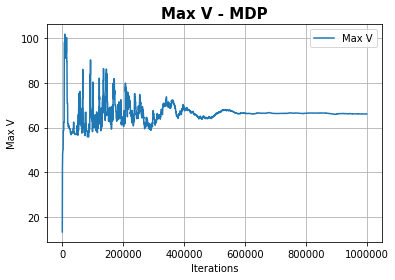

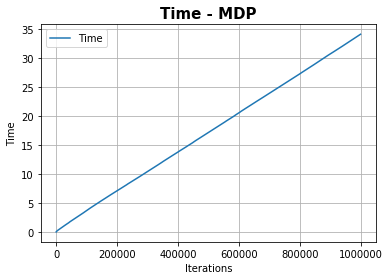

(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Counter({0: 11, 1: 4})

In [198]:
np.random.seed(252)
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm_small, R_fm_small, 0.99, n_iter = 1000000 , epsilon = 1, epsilon_decay = 0.99999,
                               alpha = 1, alpha_decay = 0.99999, skip_check=True)
ql_fm.run()
plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

In [188]:
S=100
P_fm_medium, R_fm_medium, = hiive.mdptoolbox.example.forest(S=S, p=0.2, r1 = 5, r2 = 10)
pi_fm = hiive.mdptoolbox.mdp.PolicyIteration(P_fm_medium, R_fm_medium, gamma = 0.99, max_iter=1000)
pi_fm.run()
print(pi_fm.policy)
Counter(pi_fm.policy)

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Counter({0: 11, 1: 89})

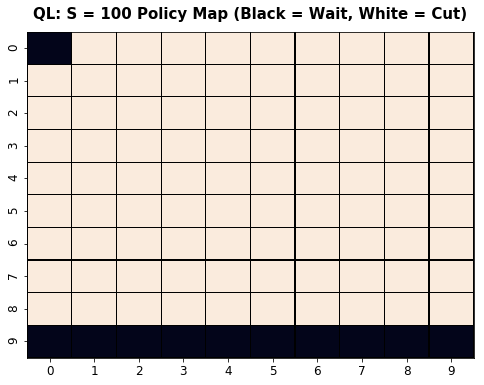

In [194]:
plot_policy_map_fm(pi_fm, title = "QL: S = 100 Policy Map (Black = Wait, White = Cut)", dimensions=(10,10))


(500, 28)


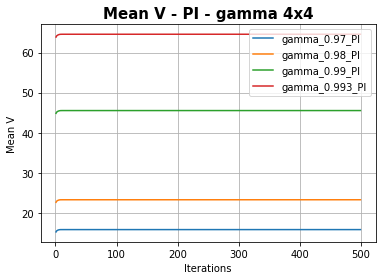

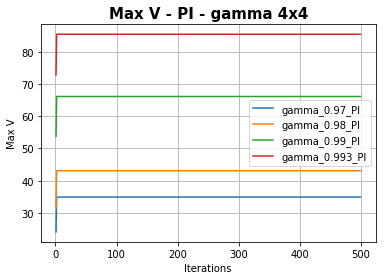

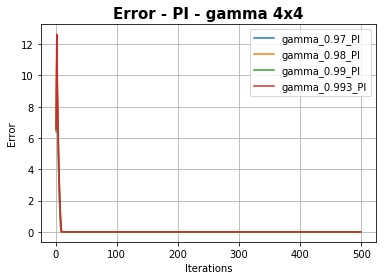

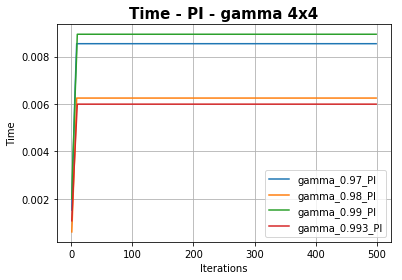

(500, 28)


In [649]:
results = analyze_param_policy(P_fm_medium, R_fm_medium)

(10000, 10)


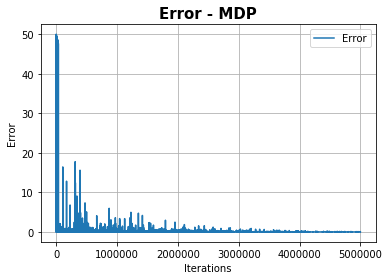

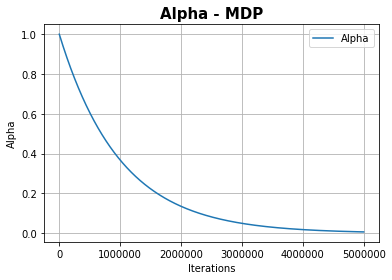

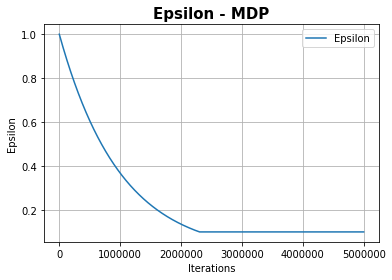

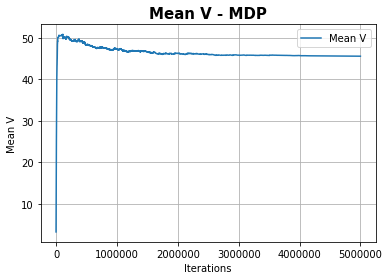

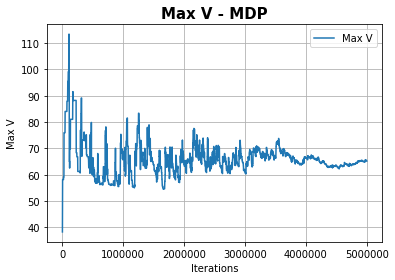

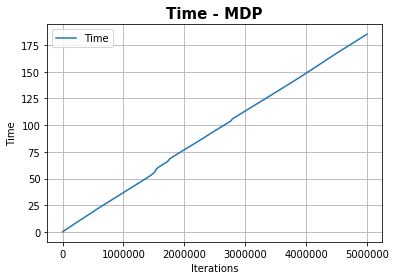

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Counter({0: 14, 1: 86})

In [199]:
np.random.seed(252)
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm_medium, R_fm_medium, 0.99, n_iter = 5000000 , epsilon = 1, epsilon_decay = 0.999999,
                               alpha = 1, alpha_decay = 0.999999, skip_check=True)
ql_fm.run()
plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

(10000, 10)


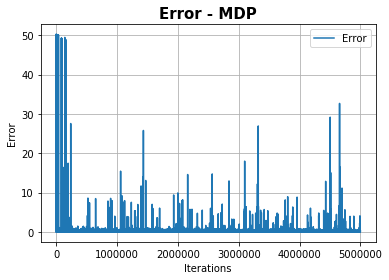

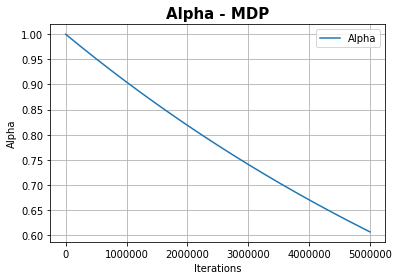

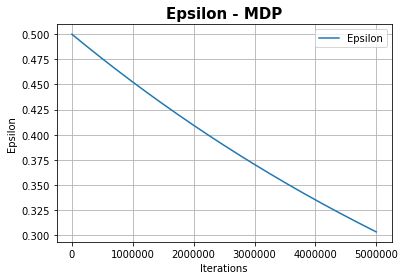

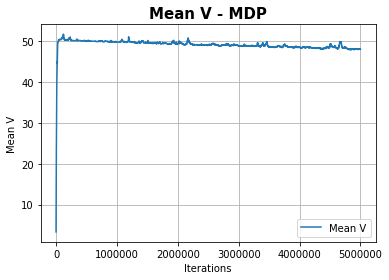

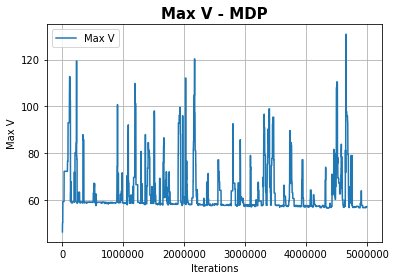

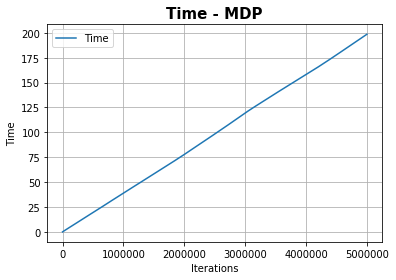

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1)


Counter({0: 9, 1: 91})

In [653]:
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm_medium, R_fm_medium, 0.99, n_iter = 5000000 , epsilon = 0.5, epsilon_decay = 0.9999999,
                               alpha = 1, alpha_decay = 0.9999999, skip_check=True)
ql_fm.run()
plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

(10000, 10)


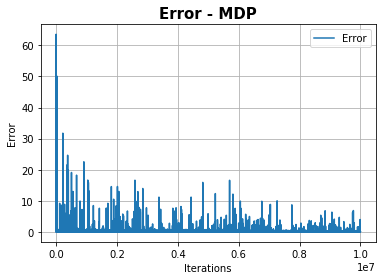

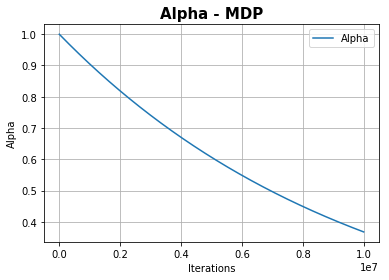

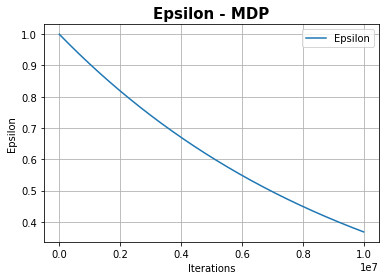

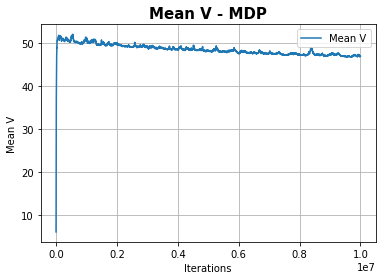

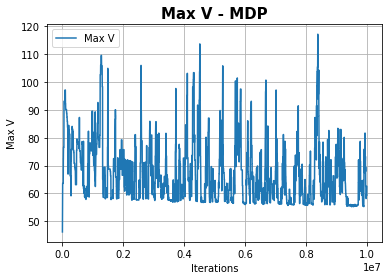

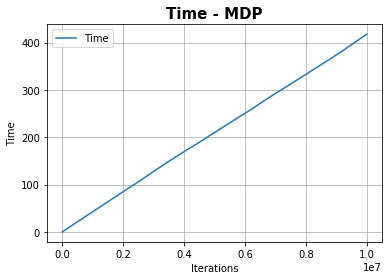

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0)


Counter({0: 6, 1: 94})

In [654]:
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm_medium, R_fm_medium, 0.99, n_iter = 10000000 , epsilon = 1, epsilon_decay = 0.9999999,
                               alpha = 1, alpha_decay = 0.9999999, skip_check=True)
ql_fm.run()
plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

(10000, 10)


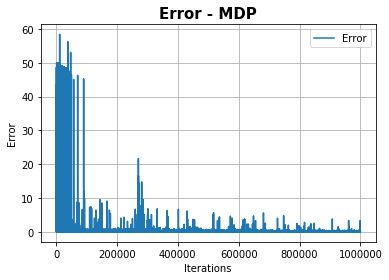

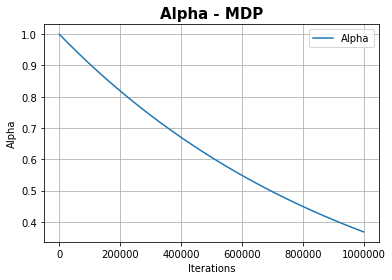

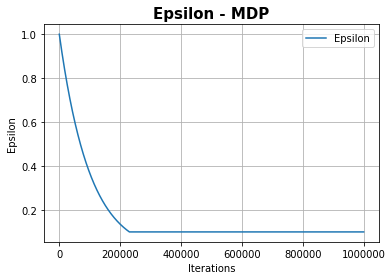

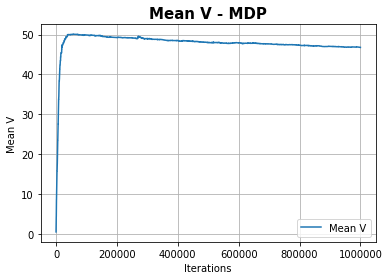

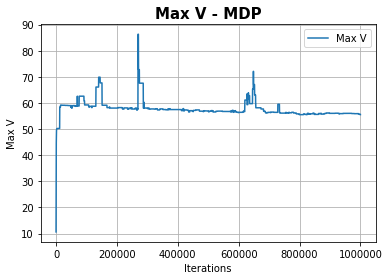

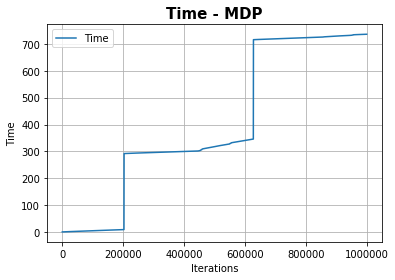

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1)


Counter({0: 6, 1: 94})

In [655]:
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm_medium, R_fm_medium, 0.99, n_iter = 1000000 , epsilon = 1, epsilon_decay = 0.99999,
                               alpha = 1, alpha_decay = 0.999999, skip_check=True)
ql_fm.run()
plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

In [186]:
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm_medium, R_fm_medium, 0.99, n_iter = 5000000 , epsilon = 1, epsilon_decay = 0.9999999,
                               alpha = 0.5, alpha_decay = 0.9999999, skip_check=True)
ql_fm.run()
plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

NameError: name 'P_fm_medium' is not defined

In [647]:
S=500
P_fm_large, R_fm_large, = hiive.mdptoolbox.example.forest(S=S, p=0.2, r1 = 5, r2 = 10)
pi_fm = hiive.mdptoolbox.mdp.PolicyIteration(P_fm_small, R_fm_small, gamma = 0.99, max_iter=1000)
pi_fm.run()
print(pi_fm.policy)
Counter(pi_fm.policy)

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Counter({0: 11, 1: 489})

(10000, 10)


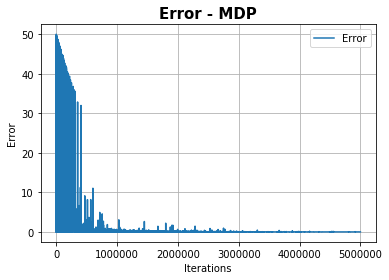

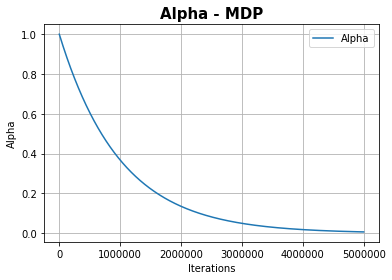

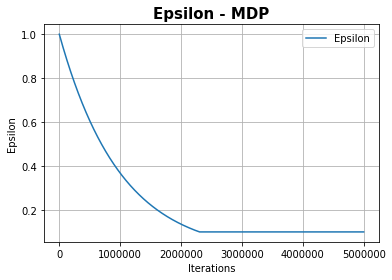

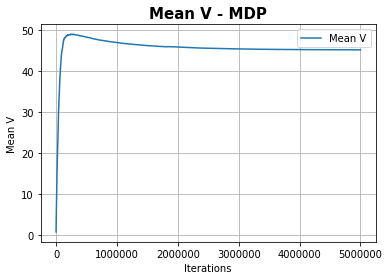

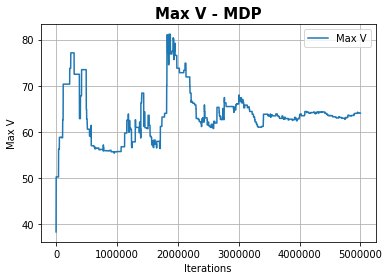

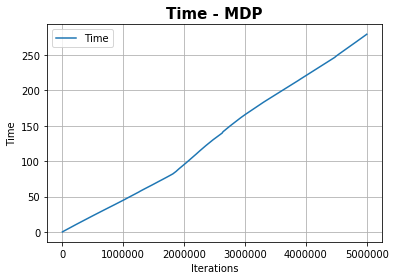

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 

Counter({0: 156, 1: 344})

In [671]:
np.random.seed(252)
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm_large, R_fm_large, 0.99, n_iter = 5000000 , epsilon = 1, epsilon_decay = 0.999999,
                               alpha = 1, alpha_decay = 0.999999, skip_check=True)
ql_fm.run()
plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

(10000, 10)


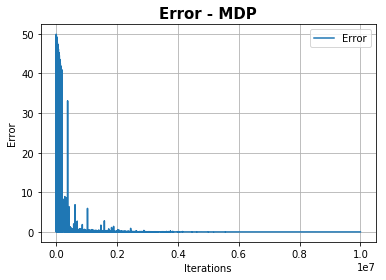

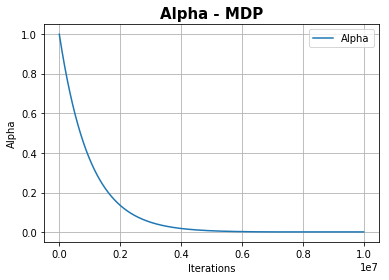

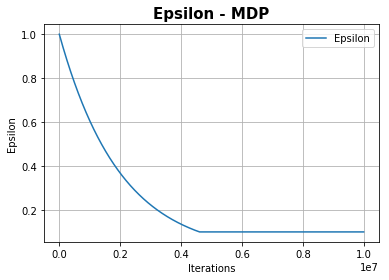

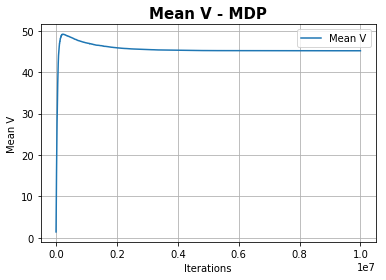

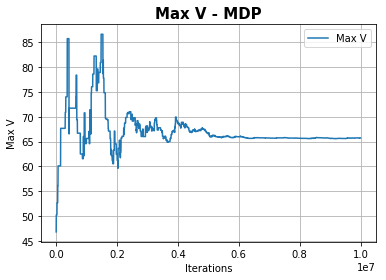

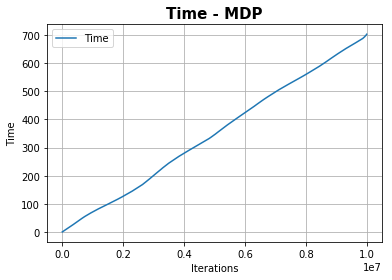

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 

Counter({0: 146, 1: 354})

In [673]:
np.random.seed(252)
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm_large, R_fm_large, 0.99, n_iter = 10000000 , epsilon = 1, epsilon_decay = 0.9999995,
                               alpha = 1, alpha_decay = 0.999999, skip_check=True)
ql_fm.run()
plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

(10000, 10)


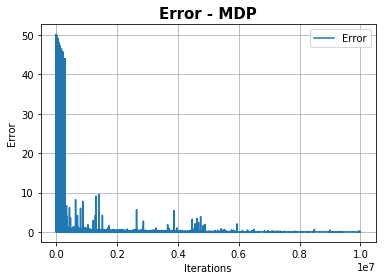

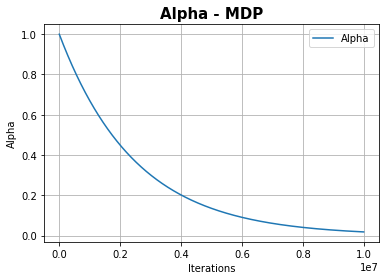

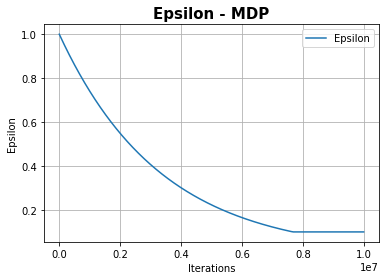

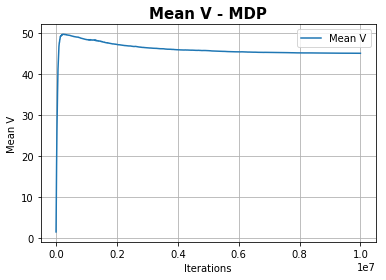

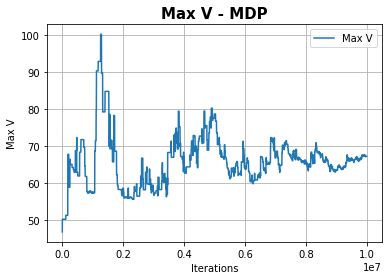

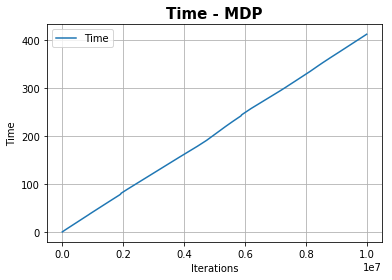

(0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 

Counter({0: 52, 1: 448})

In [172]:
#Selected
np.random.seed(252)
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm_large, R_fm_large, 0.99, n_iter = 10000000 , epsilon = 1, epsilon_decay = 0.9999997,
                               alpha = 1, alpha_decay = 0.9999996, skip_check=True)
ql_fm.run()
plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

In [176]:
ql_fm.V

(44.24926807130247,
 44.80720044908355,
 44.84326376828223,
 44.794694886921995,
 44.87896944124704,
 44.903896800342025,
 44.93339603441455,
 44.91818424677938,
 44.90419282703248,
 44.90736262732927,
 44.954278564510226,
 44.91195633867834,
 44.987395490746714,
 44.93842668695246,
 44.93084896762862,
 44.87518196199,
 44.92260764598354,
 44.922865380963195,
 44.923949573227155,
 44.95865092301687,
 44.956147650033685,
 44.90703455162891,
 44.95742357544089,
 44.90109863318705,
 44.94063047055245,
 44.896020634014185,
 44.918773183902026,
 44.93844843372982,
 44.90577598383293,
 44.94271432524622,
 44.90211821660666,
 44.93509021423484,
 44.910597491002356,
 44.9026969717331,
 44.92403706537817,
 44.91950106231134,
 44.95362717850228,
 44.92105281071196,
 44.97107047053516,
 44.898793639205415,
 44.96254250525482,
 44.960203379098914,
 44.91605221283201,
 44.92718909146058,
 44.94640346348327,
 44.952375115859425,
 44.94788427477596,
 44.970569212202804,
 44.9269606247867,
 44.8970113

In [177]:
ql_fm.Q

array([[44.24926807, 43.82890651],
       [44.27770026, 44.80720045],
       [44.20484584, 44.84326377],
       [44.35920422, 44.79469489],
       [44.63361539, 44.87896944],
       [44.89862611, 44.9038968 ],
       [44.93339603, 44.93085502],
       [44.90730644, 44.91818425],
       [44.86566213, 44.90419283],
       [44.88254989, 44.90736263],
       [44.95427856, 44.95100742],
       [44.89712726, 44.91195634],
       [44.94509718, 44.98739549],
       [44.93842669, 44.93754329],
       [44.88111908, 44.93084897],
       [44.86673698, 44.87518196],
       [44.89516992, 44.92260765],
       [44.89781856, 44.92286538],
       [44.84202509, 44.92394957],
       [44.9578568 , 44.95865092],
       [44.93067229, 44.95614765],
       [44.90384072, 44.90703455],
       [44.93486983, 44.95742358],
       [44.89510111, 44.90109863],
       [44.92368324, 44.94063047],
       [44.88696096, 44.89602063],
       [44.91459355, 44.91877318],
       [44.93351787, 44.93844843],
       [44.89489693,

In [180]:
for i in range(500):
    if ql_fm.policy[i] == 1:
        print(str(i), ql_fm.Q[i])

0 [44.24926807 43.82890651]
6 [44.93339603 44.93085502]
10 [44.95427856 44.95100742]
13 [44.93842669 44.93754329]
41 [44.96020338 44.95776633]
50 [44.93141204 44.93023901]
56 [44.9351818  44.93508687]
74 [44.8998961  44.89857573]
93 [44.92830862 44.92449469]
110 [44.93771114 44.93557377]
111 [44.94116938 44.94027343]
115 [44.89326961 44.89309804]
119 [44.95664125 44.95346015]
131 [44.9487478  44.94849483]
135 [44.94939942 44.94606807]
137 [44.92790514 44.92633446]
143 [44.91646716 44.91557231]
153 [44.91532919 44.9126291 ]
155 [44.93861938 44.93709692]
170 [44.93934948 44.93846748]
175 [44.90735216 44.90670957]
187 [44.92145733 44.92098634]
209 [44.93212138 44.92984837]
230 [44.93069651 44.93061969]
242 [44.93281043 44.93263642]
252 [44.91344839 44.91242013]
255 [44.94365603 44.94152043]
258 [44.94673919 44.94138906]
297 [44.94424656 44.9411916 ]
314 [44.91692013 44.91318854]
315 [44.95175972 44.94843327]
321 [44.93303176 44.93281515]
326 [44.94936405 44.94268027]
342 [44.91217851 44.9

In [182]:
for i in range(500):
    if ql_fm.policy[i] == 1:
        print(str(i), ql_fm.Q[i])

1 [44.27770026 44.80720045]
2 [44.20484584 44.84326377]
3 [44.35920422 44.79469489]
4 [44.63361539 44.87896944]
5 [44.89862611 44.9038968 ]
7 [44.90730644 44.91818425]
8 [44.86566213 44.90419283]
9 [44.88254989 44.90736263]
11 [44.89712726 44.91195634]
12 [44.94509718 44.98739549]
14 [44.88111908 44.93084897]
15 [44.86673698 44.87518196]
16 [44.89516992 44.92260765]
17 [44.89781856 44.92286538]
18 [44.84202509 44.92394957]
19 [44.9578568  44.95865092]
20 [44.93067229 44.95614765]
21 [44.90384072 44.90703455]
22 [44.93486983 44.95742358]
23 [44.89510111 44.90109863]
24 [44.92368324 44.94063047]
25 [44.88696096 44.89602063]
26 [44.91459355 44.91877318]
27 [44.93351787 44.93844843]
28 [44.89489693 44.90577598]
29 [44.94010754 44.94271433]
30 [44.88478788 44.90211822]
31 [44.91986774 44.93509021]
32 [44.90256894 44.91059749]
33 [44.90016723 44.90269697]
34 [44.897433   44.92403707]
35 [44.90556075 44.91950106]
36 [44.9499101  44.95362718]
37 [44.88512095 44.92105281]
38 [44.96405785 44.971

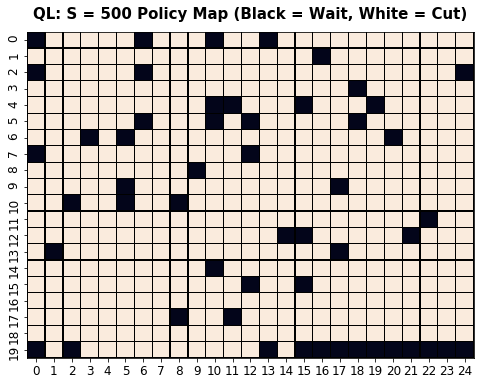

In [185]:
plot_policy_map_fm(ql_fm, title = "QL: S = 500 Policy Map (Black = Wait, White = Cut)")


(10000, 10)


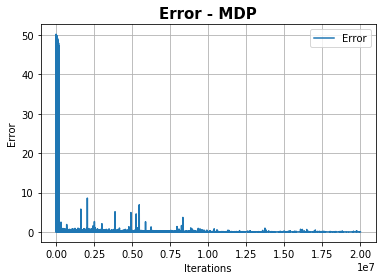

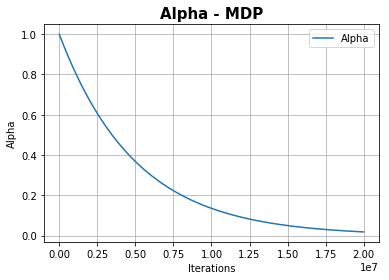

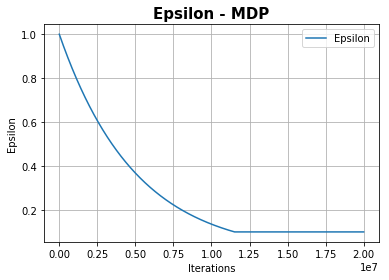

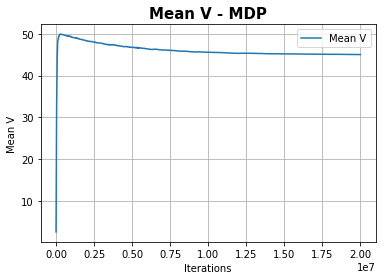

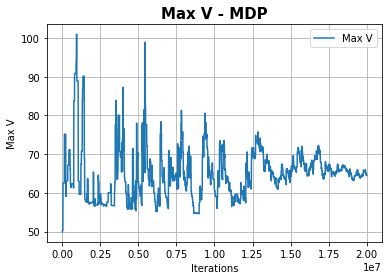

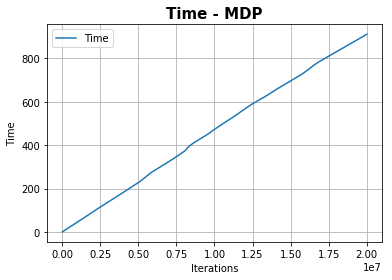

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 

Counter({0: 23, 1: 477})

In [716]:
np.random.seed(252)
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm_large, R_fm_large, 0.99, n_iter = 20000000 , epsilon = 1, epsilon_decay = 0.9999998,
                               alpha = 1, alpha_decay = 0.9999998, skip_check=True)
ql_fm.run()
plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

(10000, 10)


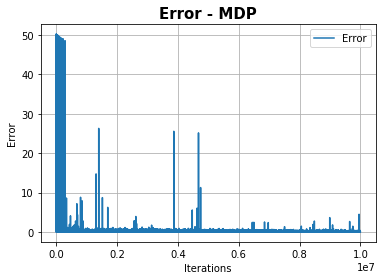

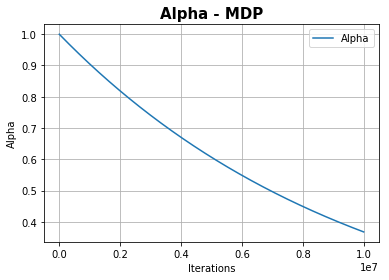

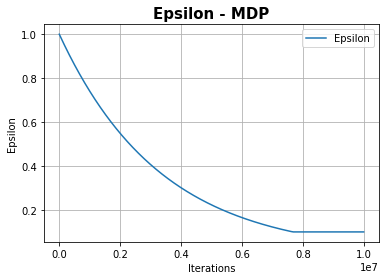

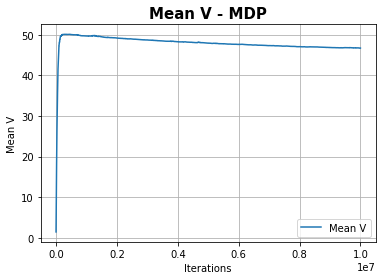

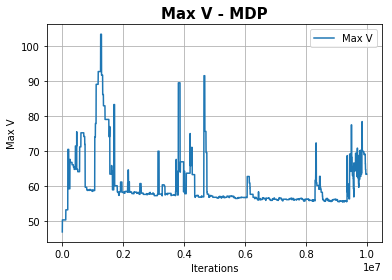

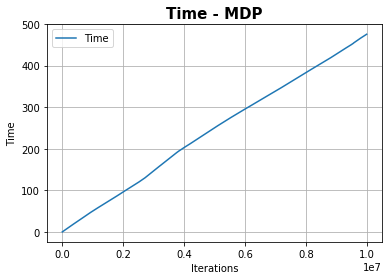

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Counter({0: 34, 1: 466})

In [675]:
np.random.seed(252)
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm_large, R_fm_large, 0.99, n_iter = 10000000 , epsilon = 1, epsilon_decay = 0.9999997,
                               alpha = 1, alpha_decay = 0.9999999, skip_check=True)
ql_fm.run()
plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

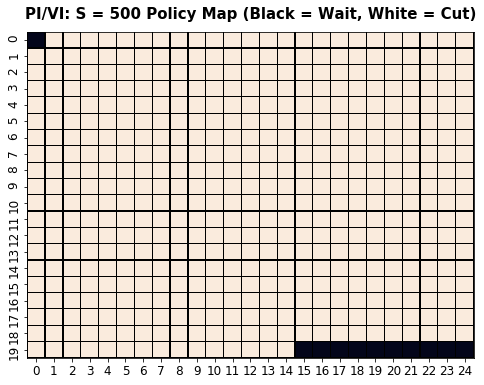

In [184]:
S=500
P_fm, R_fm, = hiive.mdptoolbox.example.forest(S=S, p=0.2, r1 = 5, r2 = 10)
pi_fm = hiive.mdptoolbox.mdp.PolicyIteration(P_fm, R_fm, gamma = 0.99, max_iter=1000)
pi_fm.run()
print(pi_fm.policy)
Counter(pi_fm.policy)
plot_policy_map_fm(pi_fm, title = "PI/VI: S = 500 Policy Map (Black = Wait, White = Cut)")

In [191]:
def plot_policy_map_fm(trained_policy, title = "Heat Map", showUtility = False, dimensions = (20,25)):
    policy = trained_policy.policy
    V = trained_policy.V
    # Plot heatmap
    
    policy_map = zip(policy)
    labels = []
    font_size = 20
#     for policy, utility in policy_map:
#         annot = ""
#         if policy == 0:
#             annot = directions_arrows()[policy] + " (S)"
#         elif square == b'H':
#             annot = directions_arrows()[policy] + " (H)"
#         elif square == b'G':
#             annot = directions_arrows()[policy] + " (G)"
#         else:
#             annot = directions_arrows()[policy]
#         if showUtility:
#             font_size = 12
#             annot = annot + " " + str('%.1f' % utility)
#         labels.append(annot)
            
#     length = int(math.sqrt(len(labels)))
#     labels = np.array(labels).reshape(length,length)

    fig, ax = plt.subplots(figsize=(8, 6))
    #g = sns.heatmap(np.array(policy).reshape(15, 1), cmap="YlGnBu", annot=labels, fmt = '', annot_kws={"size":font_size, "fontweight":'heavy'}, ax = ax)
    array =np.array(policy).reshape(dimensions[0], dimensions[1])
    g = sns.heatmap(array, ax = ax, linewidths=0.2, linecolor='black', cbar= False)
    ax.tick_params(labelsize=12)
    #cax = plt.gcf().axes[-1]
    #cax.tick_params(labelsize=15)
    plt.title(title, y = 1.02, fontsize=15, fontweight ='heavy')
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    plt.show()

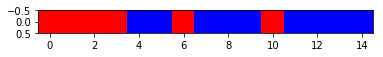

In [113]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

data = np.random.rand(1, 15) * 20

# create discrete colormap
cmap = colors.ListedColormap(['red', 'blue'])
bounds = [0,10,20]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()
ax.imshow(data, cmap=cmap, norm=norm)

# draw gridlines


plt.show()